In [ ]:
# import os, json, numpy as np

# CACHE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/cached/layer4"
# A_CACHE   = os.path.join(CACHE_DIR, "A_cls.npy")
# J_CACHE   = os.path.join(CACHE_DIR, "J_embed.npy")
# IDS_CACHE = os.path.join(CACHE_DIR, "cell_order.txt")
# MANIFEST  = os.path.join(CACHE_DIR, "manifest.json")

# # fast, zero-copy-ish loads
# A_cls   = np.load(A_CACHE, mmap_mode="r")   # shape [N, U]
# J_embed = np.load(J_CACHE, mmap_mode="r")   # shape [N, F]
# with open(IDS_CACHE, "r") as f:
#     cell_order = [ln.strip() for ln in f]

# # quick sanity (optional)
# with open(MANIFEST, "r") as f:
#     mani = json.load(f)
# assert A_cls.shape[0] == len(cell_order) == J_embed.shape[0], "Cache shape/IDs mismatch"

# print("Loaded from cache:", A_cls.shape, J_embed.shape, "N ids:", len(cell_order))

Loaded from cache: (81236, 512) (81236, 4096) N ids: 81236


In [2]:
# ==========================
# Align from cache -> A, labels, groups
# ==========================
import os, json, numpy as np, pandas as pd, scanpy as sc

# ---- paths / config
CACHE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/cached/layer4"
A_CACHE   = os.path.join(CACHE_DIR, "A_cls.npy")     # scGPT <CLS> activations
J_CACHE   = os.path.join(CACHE_DIR, "J_embed.npy")
IDS_CACHE = os.path.join(CACHE_DIR, "cell_order.txt")
H5AD_PATH = "/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad"
GROUP_COL = "patient"   # set to None if you don't want within-patient shuffles

# ---- load cache + AnnData
A_cls = np.load(A_CACHE, mmap_mode="r")  # shape [N_all, U]
with open(IDS_CACHE, "r") as f:
    cell_order_cached = [ln.strip() for ln in f]

adata = sc.read_h5ad(H5AD_PATH)

# ---- build intersection in A's order
ids_A = pd.Index(cell_order_cached)
ids_J = pd.Index(adata.obs_names.astype(str))
idx_J_for_A = ids_J.get_indexer(ids_A)  # -1 if not present in adata
keep_mask   = idx_J_for_A >= 0

idx_A_keep = np.nonzero(keep_mask)[0]    # rows in A order to keep
idx_J_keep = idx_J_for_A[keep_mask]      # corresponding rows in adata

# A_cls   = np.load(A_CACHE, mmap_mode="r")   # shape [N, U]
J_embed = np.load(J_CACHE, mmap_mode="r")   # shape [N, F]

# ---- slice and name the arrays EXACTLY as used downstream
A_for_mis       = np.asarray(A_cls[idx_A_keep], dtype=np.float32)      # [M, U]
labels_aligned  = adata.obs["author_cell_type"].to_numpy()[idx_J_keep]        # [M]

# expose the names expected by the justification script:
A      = A_for_mis
labels = labels_aligned

# optional: groups for within-group permutations/splits (patient/slide/etc.)
if GROUP_COL and (GROUP_COL in adata.obs.columns):
    groups = adata.obs[GROUP_COL].to_numpy()[idx_J_keep]
else:
    groups = None

# ---- quick sanity
print(f"[sanity] A shape: {A.shape}  | labels: {labels.shape}  | groups: {None if groups is None else groups.shape}")

[sanity] A shape: (81236, 512)  | labels: (81236,)  | groups: None


# enrichment score of high-tis units across celltypes

In [6]:
from scipy.stats import binomtest, hypergeom
from statsmodels.stats.multitest import multipletests

def hypergeo_enrichment_for_unit(u, A, labels, min_in_high=50):
    if labels is None: 
        return None
    a = A[:, u]
    high = a >= np.median(a)
    idx_high = np.where(high)[0]
    if len(idx_high) < min_in_high:
        return None

    lab = pd.Series(labels)
    lab_high = pd.Series(labels[idx_high])

    N = len(lab)
    n = len(idx_high)

    rows = []
    for label, K in lab.value_counts().items():
        k = int((lab_high == label).sum())
        # overlap k or more among n draws from population N with K "successes"
        p = hypergeom.sf(k-1, N, K, n)
        rows.append((label, k, K, n, N, p))
    df = pd.DataFrame(rows, columns=["label","k_in_high","K_in_pop","n_high","N_total","p"])
    df["p_fdr"] = multipletests(df["p"], method="fdr_bh")[1]
    df["enrichment_ratio"] = (df["k_in_high"]/df["n_high"]) / (df["K_in_pop"]/df["N_total"])
    return df.sort_values(["p_fdr","enrichment_ratio"], ascending=[True,False])

# # --- Make sure your variables are correctly defined ---
A = np.asarray(A_cls)
labels = np.asarray(labels_aligned)
# --- Base directory for the new run ---
out_dir = "./out"

# --- Load MIS results ---
MIS = np.load(f"{out_dir}/MIS_expr_zcos.npy")

with open(f"{out_dir}/summary_expr_zcos.json") as f:
    summary = json.load(f)

# Example: top 10 units
for u in [r["unit"] for r in summary["top_units"][:10]]:
    print("Unit", u, "MIS", MIS[u])
    display(hypergeo_enrichment_for_unit(u, A, labels).head(8))


Unit 246 MIS 0.845


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
2,fibroblast,11921,13609,40618,81236,0.000000e+00,0.000000e+00,1.751929
3,T CD4 memory,7411,9344,40618,81236,0.000000e+00,0.000000e+00,1.586259
7,plasmablast,1513,1638,40618,81236,1.267523e-308,9.295167e-308,1.847375
8,mast,1391,1487,40618,81236,1.047428e-299,5.760856e-299,1.870881
6,Treg,1886,2244,40618,81236,1.814553e-256,7.984032e-256,1.680927
5,pDC,2135,2702,40618,81236,1.248822e-219,4.579014e-219,1.580311
10,neutrophil,352,412,40618,81236,6.895189e-52,2.167059e-51,1.708738
12,T CD8 naive,175,184,40618,81236,1.981493e-41,5.449105e-41,1.902174


Unit 437 MIS 0.825


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,20770,26030,40618,81236,0.000000,0.000000,1.595851
9,endothelial,791,1449,40618,81236,0.000232,0.002547,1.091787
1,macrophage,9147,17989,40618,81236,0.005102,0.037418,1.016955
4,T CD8 memory,1162,3067,40618,81236,1.000000,1.000000,0.757744
3,T CD4 memory,3172,9344,40618,81236,1.000000,1.000000,0.678938
11,mDC,106,338,40618,81236,1.000000,1.000000,0.627219
2,fibroblast,4085,13609,40618,81236,1.000000,1.000000,0.600338
5,pDC,664,2702,40618,81236,1.000000,1.000000,0.491488


Unit 467 MIS 0.805


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
2,fibroblast,12058,13609,40618,81236,0.000000e+00,0.000000e+00,1.772063
3,T CD4 memory,8212,9344,40618,81236,0.000000e+00,0.000000e+00,1.757705
8,mast,1385,1487,40618,81236,9.444566e-293,6.926015e-292,1.862811
6,Treg,1729,2244,40618,81236,7.236646e-157,3.980156e-156,1.540998
5,pDC,1833,2702,40618,81236,3.699197e-81,1.627647e-80,1.356773
7,plasmablast,1190,1638,40618,81236,2.149129e-79,7.880141e-79,1.452991
10,neutrophil,332,412,40618,81236,4.924136e-38,1.547586e-37,1.611650
12,T CD8 naive,172,184,40618,81236,8.158655e-38,2.243630e-37,1.869565


Unit 55 MIS 0.78


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,25346,26030,40618,81236,0.000000e+00,0.000000e+00,1.947445
6,Treg,1624,2244,40618,81236,4.178101e-106,4.595912e-105,1.447415
4,T CD8 memory,2003,3067,40618,81236,4.118266e-68,3.020061e-67,1.306162
7,plasmablast,1109,1638,40618,81236,1.279085e-48,7.034969e-48,1.354090
10,neutrophil,333,412,40618,81236,1.169958e-38,5.147814e-38,1.616505
13,tumor 9,148,170,40618,81236,1.793582e-24,6.576467e-24,1.741176
14,epithelial,110,132,40618,81236,1.364076e-15,4.287095e-15,1.666667
12,T CD8 naive,130,184,40618,81236,9.875154e-09,2.715667e-08,1.413043


Unit 213 MIS 0.7775


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,22213,26030,40618,81236,0.000000e+00,0.000000e+00,1.706723
1,macrophage,9958,17989,40618,81236,6.117135e-60,6.728849e-59,1.107121
4,T CD8 memory,1869,3067,40618,81236,1.658207e-35,1.216019e-34,1.218781
11,mDC,191,338,40618,81236,9.478861e-03,5.213373e-02,1.130178
8,mast,560,1487,40618,81236,1.000000e+00,1.000000e+00,0.753194
6,Treg,843,2244,40618,81236,1.000000e+00,1.000000e+00,0.751337
17,B-cell,24,70,40618,81236,9.972188e-01,1.000000e+00,0.685714
3,T CD4 memory,2919,9344,40618,81236,1.000000e+00,1.000000e+00,0.624786


Unit 196 MIS 0.775


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,24391,26030,40618,81236,0.000000e+00,0.000000e+00,1.874068
4,T CD8 memory,2320,3067,40618,81236,5.120284e-193,5.632313e-192,1.512879
6,Treg,1467,2244,40618,81236,2.734892e-50,2.005587e-49,1.307487
12,T CD8 naive,153,184,40618,81236,6.279403e-21,3.453671e-20,1.663043
15,NK,85,105,40618,81236,4.912775e-11,2.161621e-10,1.619048
13,tumor 9,110,170,40618,81236,7.624572e-05,2.795676e-04,1.294118
14,epithelial,87,132,40618,81236,1.597967e-04,5.022182e-04,1.318182
19,T CD4 naive,41,62,40618,81236,7.547907e-03,2.075675e-02,1.322581


Unit 292 MIS 0.7725


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
2,fibroblast,11095,13609,40618,81236,0.000000e+00,0.000000e+00,1.630539
1,macrophage,14578,17989,40618,81236,0.000000e+00,0.000000e+00,1.620768
3,T CD4 memory,6539,9344,40618,81236,0.000000e+00,0.000000e+00,1.399615
5,pDC,1953,2702,40618,81236,5.458871e-127,3.002379e-126,1.445596
8,mast,1002,1487,40618,81236,1.099372e-42,4.837237e-42,1.347680
11,mDC,286,338,40618,81236,9.795671e-41,3.591746e-40,1.692308
16,monocyte,62,93,40618,81236,8.512247e-04,2.675278e-03,1.333333
7,plasmablast,848,1638,40618,81236,7.738806e-02,2.128172e-01,1.035409


Unit 346 MIS 0.7725


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,22185,26030,40618,81236,0.000000,0.0,1.704572
13,tumor 9,72,170,40618,81236,0.981069,1.0,0.847059
1,macrophage,6732,17989,40618,81236,1.000000,1.0,0.748457
2,fibroblast,4612,13609,40618,81236,1.000000,1.0,0.677787
3,T CD4 memory,3162,9344,40618,81236,1.000000,1.0,0.676798
8,mast,478,1487,40618,81236,1.000000,1.0,0.642905
4,T CD8 memory,974,3067,40618,81236,1.000000,1.0,0.635148
5,pDC,850,2702,40618,81236,1.000000,1.0,0.629164


Unit 382 MIS 0.77


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
7,plasmablast,1527,1638,40618,81236,0.000000e+00,0.000000e+00,1.864469
5,pDC,2347,2702,40618,81236,0.000000e+00,0.000000e+00,1.737232
3,T CD4 memory,5821,9344,40618,81236,2.386328e-142,1.749974e-141,1.245933
6,Treg,1668,2244,40618,81236,5.597477e-126,3.078612e-125,1.486631
2,fibroblast,8036,13609,40618,81236,3.286175e-119,1.445917e-118,1.180983
1,macrophage,10228,17989,40618,81236,5.744488e-97,2.106312e-96,1.137139
11,mDC,323,338,40618,81236,4.998691e-77,1.571017e-76,1.911243
8,mast,1079,1487,40618,81236,1.444315e-71,3.971865e-71,1.451244


Unit 187 MIS 0.77


,label,k_in_high,K_in_pop,n_high,N_total,p,p_fdr,enrichment_ratio
0,tumor 13,21833,26030,40618,81236,0.000000e+00,0.000000e+00,1.677526
1,macrophage,10232,17989,40618,81236,1.386802e-97,1.525483e-96,1.137584
4,T CD8 memory,2033,3067,40618,81236,5.623388e-77,4.123818e-76,1.325725
9,endothelial,762,1449,40618,81236,2.488772e-02,1.368824e-01,1.051760
6,Treg,842,2244,40618,81236,1.000000e+00,1.000000e+00,0.750446
5,pDC,802,2702,40618,81236,1.000000e+00,1.000000e+00,0.593634
15,NK,31,105,40618,81236,9.999935e-01,1.000000e+00,0.590476
21,tumor 5,6,23,40618,81236,9.946943e-01,1.000000e+00,0.521739


In [1]:
# -----------------------
# Illustrator-friendly style
# -----------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
sns.set_context("paper"); sns.set_style("white")

In [14]:
# Build a unit x rank table of top enriched cell types
TOP_K = 15
units = [r["unit"] for r in summary["top_units"][:20]]  # same selection you used

rows_labels = {}
rows_formatted = {}

for u in units:
    df = hypergeo_enrichment_for_unit(u, A, labels)  # already sorted by p_fdr then enrichment_ratio
    if df is None or df.empty:
        continue
    top = df.head(TOP_K).reset_index(drop=True)

    # just the labels
    rows_labels[u] = top["label"].tolist()

    # label + scores (enrichment ratio and FDR)
    rows_formatted[u] = [
        f"{row.label} (ER={row.enrichment_ratio:.2f}, FDR={row.p_fdr:.1e})"
        for row in top.itertuples(index=False)
    ]

# pad to the same number of ranks
def pad_rows(d):
    if not d: 
        return d
    maxk = max(len(v) for v in d.values())
    for k, v in d.items():
        if len(v) < maxk:
            d[k] = v + [""] * (maxk - len(v))
    return d

rows_labels   = pad_rows(rows_labels)
rows_formatted = pad_rows(rows_formatted)

rank_cols = [f"rank{i+1}" for i in range(len(next(iter(rows_labels.values()), [])))]

# (A) table with just cell-type names
enrich_table = pd.DataFrame.from_dict(rows_labels, orient="index", columns=rank_cols).sort_index()
enrich_table.index.name = "unit"

# (B) table with cell-type + (ER, FDR)
enrich_table_with_scores = pd.DataFrame.from_dict(rows_formatted, orient="index", columns=rank_cols).sort_index()
enrich_table_with_scores.index.name = "unit"

display(enrich_table)
display(enrich_table_with_scores)

,rank1,rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11,rank12,rank13,rank14,rank15
unit,,,,,,,,,,,,,,,
3,tumor 13,tumor 12,endothelial,tumor 9,epithelial,macrophage,tumor 5,B-cell,tumor 6,monocyte,T CD8 memory,mast,mDC,neutrophil,fibroblast
13,tumor 13,endothelial,T CD8 memory,epithelial,monocyte,tumor 6,mast,NK,tumor 5,macrophage,neutrophil,tumor 12,tumor 9,T CD4 naive,T CD8 naive
41,tumor 13,endothelial,fibroblast,tumor 6,macrophage,tumor 5,plasmablast,T CD8 memory,mast,pDC,T CD4 memory,B-cell,epithelial,monocyte,mDC
55,tumor 13,Treg,T CD8 memory,plasmablast,neutrophil,tumor 9,epithelial,T CD8 naive,NK,tumor 12,T CD4 naive,B-cell,tumor 5,tumor 6,monocyte
149,macrophage,tumor 13,endothelial,mast,mDC,fibroblast,monocyte,pDC,T CD4 memory,T CD8 memory,plasmablast,Treg,B-cell,tumor 12,NK
187,tumor 13,macrophage,T CD8 memory,endothelial,Treg,pDC,NK,tumor 5,epithelial,tumor 9,T CD4 memory,T CD8 naive,mDC,T CD4 naive,mast
194,fibroblast,T CD4 memory,plasmablast,pDC,mast,Treg,mDC,T CD8 naive,T CD4 naive,tumor 9,NK,macrophage,monocyte,tumor 5,B-cell
196,tumor 13,T CD8 memory,Treg,T CD8 naive,NK,tumor 9,epithelial,T CD4 naive,B-cell,tumor 5,mast,tumor 12,T CD4 memory,neutrophil,tumor 6
198,tumor 13,macrophage,T CD8 memory,T CD4 memory,fibroblast,Treg,epithelial,endothelial,pDC,monocyte,B-cell,tumor 9,NK,T CD4 naive,T CD8 naive


,rank1,rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11,rank12,rank13,rank14,rank15
unit,,,,,,,,,,,,,,,
3,"tumor 13 (ER=1.77, FDR=0.0e+00)","tumor 12 (ER=1.16, FDR=1.0e+00)","endothelial (ER=1.01, FDR=1.0e+00)","tumor 9 (ER=0.96, FDR=1.0e+00)","epithelial (ER=0.94, FDR=1.0e+00)","macrophage (ER=0.91, FDR=1.0e+00)","tumor 5 (ER=0.87, FDR=1.0e+00)","B-cell (ER=0.83, FDR=1.0e+00)","tumor 6 (ER=0.77, FDR=1.0e+00)","monocyte (ER=0.73, FDR=1.0e+00)","T CD8 memory (ER=0.72, FDR=1.0e+00)","mast (ER=0.67, FDR=1.0e+00)","mDC (ER=0.64, FDR=1.0e+00)","neutrophil (ER=0.64, FDR=1.0e+00)","fibroblast (ER=0.53, FDR=1.0e+00)"
13,"tumor 13 (ER=1.83, FDR=0.0e+00)","endothelial (ER=1.38, FDR=7.4e-48)","T CD8 memory (ER=0.92, FDR=1.0e+00)","epithelial (ER=0.91, FDR=1.0e+00)","monocyte (ER=0.86, FDR=1.0e+00)","tumor 6 (ER=0.85, FDR=1.0e+00)","mast (ER=0.82, FDR=1.0e+00)","NK (ER=0.80, FDR=1.0e+00)","tumor 5 (ER=0.78, FDR=1.0e+00)","macrophage (ER=0.76, FDR=1.0e+00)","neutrophil (ER=0.69, FDR=1.0e+00)","tumor 12 (ER=0.68, FDR=1.0e+00)","tumor 9 (ER=0.66, FDR=1.0e+00)","T CD4 naive (ER=0.65, FDR=1.0e+00)","T CD8 naive (ER=0.58, FDR=1.0e+00)"
41,"tumor 13 (ER=1.83, FDR=0.0e+00)","endothelial (ER=0.80, FDR=1.0e+00)","fibroblast (ER=0.74, FDR=1.0e+00)","tumor 6 (ER=0.69, FDR=1.0e+00)","macrophage (ER=0.66, FDR=1.0e+00)","tumor 5 (ER=0.61, FDR=1.0e+00)","plasmablast (ER=0.59, FDR=1.0e+00)","T CD8 memory (ER=0.59, FDR=1.0e+00)","mast (ER=0.58, FDR=1.0e+00)","pDC (ER=0.49, FDR=1.0e+00)","T CD4 memory (ER=0.46, FDR=1.0e+00)","B-cell (ER=0.43, FDR=1.0e+00)","epithelial (ER=0.42, FDR=1.0e+00)","monocyte (ER=0.39, FDR=1.0e+00)","mDC (ER=0.35, FDR=1.0e+00)"
55,"tumor 13 (ER=1.95, FDR=0.0e+00)","Treg (ER=1.45, FDR=4.6e-105)","T CD8 memory (ER=1.31, FDR=3.0e-67)","plasmablast (ER=1.35, FDR=7.0e-48)","neutrophil (ER=1.62, FDR=5.1e-38)","tumor 9 (ER=1.74, FDR=6.6e-24)","epithelial (ER=1.67, FDR=4.3e-15)","T CD8 naive (ER=1.41, FDR=2.7e-08)","NK (ER=1.47, FDR=2.2e-06)","tumor 12 (ER=1.58, FDR=4.8e-06)","T CD4 naive (ER=1.58, FDR=4.8e-06)","B-cell (ER=1.43, FDR=4.0e-04)","tumor 5 (ER=1.74, FDR=4.1e-04)","tumor 6 (ER=1.54, FDR=7.3e-03)","monocyte (ER=0.95, FDR=1.0e+00)"
149,"macrophage (ER=1.41, FDR=0.0e+00)","tumor 13 (ER=1.18, FDR=5.7e-263)","endothelial (ER=1.41, FDR=4.7e-58)","mast (ER=0.95, FDR=1.0e+00)","mDC (ER=0.92, FDR=1.0e+00)","fibroblast (ER=0.84, FDR=1.0e+00)","monocyte (ER=0.75, FDR=1.0e+00)","pDC (ER=0.72, FDR=1.0e+00)","T CD4 memory (ER=0.56, FDR=1.0e+00)","T CD8 memory (ER=0.51, FDR=1.0e+00)","plasmablast (ER=0.34, FDR=1.0e+00)","Treg (ER=0.24, FDR=1.0e+00)","B-cell (ER=0.20, FDR=1.0e+00)","tumor 12 (ER=0.19, FDR=1.0e+00)","NK (ER=0.19, FDR=1.0e+00)"
187,"tumor 13 (ER=1.68, FDR=0.0e+00)","macrophage (ER=1.14, FDR=1.5e-96)","T CD8 memory (ER=1.33, FDR=4.1e-76)","endothelial (ER=1.05, FDR=1.4e-01)","Treg (ER=0.75, FDR=1.0e+00)","pDC (ER=0.59, FDR=1.0e+00)","NK (ER=0.59, FDR=1.0e+00)","tumor 5 (ER=0.52, FDR=1.0e+00)","epithelial (ER=0.48, FDR=1.0e+00)","tumor 9 (ER=0.48, FDR=1.0e+00)","T CD4 memory (ER=0.47, FDR=1.0e+00)","T CD8 naive (ER=0.43, FDR=1.0e+00)","mDC (ER=0.43, FDR=1.0e+00)","T CD4 naive (ER=0.42, FDR=1.0e+00)","mast (ER=0.39, FDR=1.0e+00)"
194,"fibroblast (ER=1.86, FDR=0.0e+00)","T CD4 memory (ER=1.53, FDR=0.0e+00)","plasmablast (ER=1.76, FDR=7.3e-240)","pDC (ER=1.43, FDR=3.1e-118)","mast (ER=1.44, FDR=1.6e-67)","Treg (ER=1.24, FDR=6.1e-30)","mDC (ER=1.29, FDR=1.6e-07)","T CD8 naive (ER=1.33, FDR=1.6e-05)","T CD4 naive (ER=1.39, FDR=3.8e-03)","tumor 9 (ER=1.20, FDR=1.2e-02)","NK (ER=1.24, FDR=1.9e-02)","macrophage (ER=1.01, FDR=1.0e-01)","monocyte (ER=1.16, FDR=1.2e-01)","tumor 5 (ER=1.30, FDR=1.6e-01)","B-cell (ER=1.14, FDR=2.1e-01)"
196,"tumor 13 (ER=1.87, FDR=0.0e+00)","T CD8 memory (ER=1.51, FDR=5.6e-192)","Treg (ER=1.31, FDR=2.0e-49)","T CD8 naive (ER=1.66, FDR=3.5e-20)","NK (ER=1.62, FDR=2.2e-10)","tumor 9 (ER=1.29, FDR=2.8e-04)","epithelial (ER=1.32, FDR=5.0e-04)","T CD4 naive (ER=1.32, FDR=2.1e-02)","B-cell (ER=1.23, FDR

In [5]:
# ============================================
# Justify 3 archetypes from MIS enrichment
# Tumor / TME (immune+stromal) / Interface
# ============================================
import numpy as np, pandas as pd
from math import log10
from scipy.stats import ks_2samp
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from typing import Dict 

# ---- Assumed available in your session ----
# - hypergeo_enrichment_for_unit(u, A, labels, min_in_high=50)
# - MIS (np.ndarray length = #units in A)
# - summary (dict from summary_expr_*.json) with "top_units" list[{unit,MIS},...]
# - A (cells x units), labels (array[str] for each cell)
# - adata (optional, only if you want patient/slide-aware permutations/splits)

# ============================================
# 0) CONFIG
# ============================================
TOP_UNITS = 50           # how many MIS-top units to consider
ALPHA_FDR = 0.05         # significance
USE_ER_POWER = 1.0       # weight ER^p inside score (1.0 = linear)
EPS_FDR = 1e-300         # floor to avoid -log10(0)
MIN_HIGH = 200           # min # high-activation cells to run enrichment (guard)
GROUP_COL = "patient"    # for within-group permutation/split; set None if unavailable

# label binning rules (coarse-grain masks)
def is_tumor(lbl: str) -> bool:
    s = str(lbl).lower()
    return s.startswith("tumor") or ("malig" in s) or ("carcin" in s)

def is_tme(lbl: str) -> bool:
    # everything non-tumor is considered TME (immune+stromal)
    return not is_tumor(lbl)

# ============================================
# 1) Collect per-unit enrichment tables
# ============================================
units_sorted = [rec["unit"] for rec in summary["top_units"][:TOP_UNITS]]

enrich_by_unit: Dict[int, pd.DataFrame] = {}
for u in units_sorted:
    df = hypergeo_enrichment_for_unit(u, A, labels, min_in_high=MIN_HIGH)
    if df is None or df.empty:
        continue
    # keep only columns we need; ensure numeric dtypes
    keep = ["label","k_in_high","K_in_pop","n_high","N_total","p","p_fdr","enrichment_ratio"]
    df = df[keep].copy()
    df["p_fdr"] = df["p_fdr"].astype(float).clip(lower=EPS_FDR)
    df["enrichment_ratio"] = df["enrichment_ratio"].astype(float)
    enrich_by_unit[u] = df

if not enrich_by_unit:
    raise RuntimeError("No enrichment tables computed; relax MIN_HIGH or TOP_UNITS?")

# ============================================
# 2) Build archetype scores per unit
#   Tumor score T_u = sum_{tumor labels with FDR<=α} [-log10(FDR) * ER^p]
#   TME   score E_u = sum_{tme   labels with FDR<=α} [-log10(FDR) * ER^p]
#   Interface I_u   = min(T_u, E_u)  (only if both sides have ≥1 sig label; else 0)
# ============================================
rows = []
for u, df in enrich_by_unit.items():
    df = df.copy()
    df["is_tumor"] = df["label"].map(is_tumor)
    df["is_tme"]   = ~df["is_tumor"]

    df_sig = df[df["p_fdr"] <= ALPHA_FDR].copy()
    # components (allow empty -> 0)
    T_comp = df_sig[df_sig["is_tumor"]]
    E_comp = df_sig[df_sig["is_tme"]]

    def score(part):
        if part.empty: return 0.0
        # weight by ER^p; clamp ER>=0 to be safe
        er = np.clip(part["enrichment_ratio"].to_numpy(float), 0, None) ** USE_ER_POWER
        return float(np.sum((-np.log10(part["p_fdr"].to_numpy(float))) * er))

    T_u = score(T_comp)
    E_u = score(E_comp)

    # interface only when both sides show significant labels
    if (not T_comp.empty) and (not E_comp.empty):
        I_u = min(T_u, E_u)  # conservative; alternatives: np.sqrt(T_u*E_u)
    else:
        I_u = 0.0

    rows.append({
        "unit": u,
        "MIS": float(MIS[u]) if (0 <= u < len(MIS)) else np.nan,
        "T_score": T_u,
        "E_score": E_u,
        "I_score": I_u,
        "n_sig_tumor": int(len(T_comp)),
        "n_sig_tme":   int(len(E_comp)),
    })

unit_scores = pd.DataFrame(rows).set_index("unit").sort_values(["I_score","T_score","E_score"], ascending=False)
display(unit_scores.head(10))

# ============================================
# 3) Call archetype per unit (crisp, conservative)
# ============================================
# Define thresholds relative to distribution to avoid hand-tuning:
T_thr = unit_scores["T_score"].quantile(0.75)
E_thr = unit_scores["E_score"].quantile(0.75)
I_thr = unit_scores["I_score"].quantile(0.75)

def call_archetype(row):
    T, E, I = row["T_score"], row["E_score"], row["I_score"]
    has_T = row["n_sig_tumor"] > 0
    has_E = row["n_sig_tme"]   > 0

    if has_T and (T >= T_thr) and not (has_E and E >= E_thr):
        return "Tumor"
    if has_E and (E >= E_thr) and not (has_T and T >= T_thr):
        return "TME"
    if has_T and has_E and (I >= I_thr):
        return "Interface"
    return "Unclear"

unit_scores["call"] = unit_scores.apply(call_archetype, axis=1)
display(unit_scores[["MIS","T_score","E_score","I_score","call"]].head(20))

# ============================================
# 4) Permutation test for Interface signal (within-group shuffle)
#    -> evidence that I_score is not due to label prevalence alone
# ============================================
def permute_within_groups(labels_arr, groups_arr):
    labels_arr = np.asarray(labels_arr)
    if groups_arr is None:
        return np.random.permutation(labels_arr)
    out = labels_arr.copy()
    groups_arr = np.asarray(groups_arr)
    for g in np.unique(groups_arr):
        idx = np.where(groups_arr == g)[0]
        out[idx] = np.random.permutation(out[idx])
    return out

def compute_I_scores_for_labels(labels_arr, units):
    I_scores = []
    for u in units:
        df = hypergeo_enrichment_for_unit(u, A, labels_arr, min_in_high=MIN_HIGH)
        if df is None or df.empty:
            I_scores.append(0.0); continue
        df = df.copy()
        df["p_fdr"] = df["p_fdr"].astype(float).clip(lower=EPS_FDR)
        df["enrichment_ratio"] = df["enrichment_ratio"].astype(float)
        df["is_tumor"] = df["label"].map(is_tumor)
        df["is_tme"]   = ~df["is_tumor"]
        df_sig = df[df["p_fdr"] <= ALPHA_FDR]
        T_comp = df_sig[df_sig["is_tumor"]]
        E_comp = df_sig[df_sig["is_tme"]]
        if T_comp.empty or E_comp.empty: 
            I_scores.append(0.0)
        else:
            def score(part):
                er = np.clip(part["enrichment_ratio"].to_numpy(float), 0, None) ** USE_ER_POWER
                return float(np.sum((-np.log10(part["p_fdr"].to_numpy(float))) * er))
            T_u = score(T_comp); E_u = score(E_comp)
            I_scores.append(min(T_u, E_u))
    return np.array(I_scores, dtype=float)

# group array for within-patient shuffles (if present)
groups = None
if GROUP_COL and GROUP_COL in adata.obs.columns:
    groups = adata.obs[GROUP_COL].to_numpy()[aligned["idx_J_keep"]]

units_eval = list(unit_scores.index)  # evaluate all we scored above

I_real = unit_scores.loc[units_eval, "I_score"].to_numpy(float)
N_PERM = 100
I_perm_all = []
rng = np.random.default_rng(0)
for _ in range(N_PERM):
    labels_perm = permute_within_groups(labels, groups)
    I_perm = compute_I_scores_for_labels(labels_perm, units_eval)
    I_perm_all.append(I_perm)
I_perm_all = np.vstack(I_perm_all)  # [N_PERM, #units]

# Compare distributions (KS test on pooled values)
ks = ks_2samp(I_real, I_perm_all.ravel(), alternative="greater")
print(f"[Permutation] KS p-value (real > null): {ks.pvalue:.3e}")
print("Real I_score 95th:", np.percentile(I_real, 95), 
      "Null 95th:", np.percentile(I_perm_all, 95))

# Optional: mark units above null 95th as strong-interface candidates
I_null95 = float(np.percentile(I_perm_all, 95))
unit_scores["interface_strong"] = unit_scores["I_score"] > I_null95

# ============================================
# 5) Split-half reproducibility (by group)
# ============================================
def split_scores(labels_arr, groups_arr, units):
    # two disjoint splits by groups (patients); if no groups, random split
    if groups_arr is None:
        idx = np.arange(len(labels_arr))
        rng = np.random.default_rng(1)
        rng.shuffle(idx)
        half = len(idx)//2
        splits = [idx[:half], idx[half:]]
    else:
        uniq = pd.unique(groups_arr)
        rng = np.random.default_rng(1)
        rng.shuffle(uniq)
        half = len(uniq)//2
        g1 = set(uniq[:half]); g2 = set(uniq[half:])
        s1 = np.where(np.isin(groups_arr, list(g1)))[0]
        s2 = np.where(np.isin(groups_arr, list(g2)))[0]
        splits = [s1, s2]

    out = []
    for idx in splits:
        A_sub = A[idx]              # used only by hypergeo_enrichment_for_unit via 'A' global
        labels_sub = labels_arr[idx]
        # temporarily swap globals (lightweight) to reuse your function
        A_backup, labels_backup = A.copy(), labels.copy()
        try:
            globals()["A"] = A_sub
            globals()["labels"] = labels_sub
            # compute T, E, I per split
            vals = {}
            for u in units:
                df = hypergeo_enrichment_for_unit(u, A_sub, labels_sub, min_in_high=max(50, int(len(idx)*0.2)))
                if df is None or df.empty:
                    vals[u] = (0.0, 0.0, 0.0); continue
                df = df.copy()
                df["p_fdr"] = df["p_fdr"].astype(float).clip(lower=EPS_FDR)
                df["enrichment_ratio"] = df["enrichment_ratio"].astype(float)
                df["is_tumor"] = df["label"].map(is_tumor)
                df["is_tme"]   = ~df["is_tumor"]
                df_sig = df[df["p_fdr"] <= ALPHA_FDR]
                T_comp = df_sig[df_sig["is_tumor"]]
                E_comp = df_sig[df_sig["is_tme"]]
                def score(part):
                    if part.empty: return 0.0
                    er = np.clip(part["enrichment_ratio"].to_numpy(float), 0, None) ** USE_ER_POWER
                    return float(np.sum((-np.log10(part["p_fdr"].to_numpy(float))) * er))
                T_u = score(T_comp); E_u = score(E_comp)
                I_u = min(T_u, E_u) if (not T_comp.empty and not E_comp.empty) else 0.0
                vals[u] = (T_u, E_u, I_u)
            out.append(pd.DataFrame(vals, index=["T","E","I"]).T)
        finally:
            globals()["A"] = A_backup
            globals()["labels"] = labels_backup
    return out[0], out[1]

if groups is not None or True:  # run regardless; falls back to random split if groups None
    split1, split2 = split_scores(labels, groups, units_eval)
    # align and compute correlations on present units
    both = split1.index.intersection(split2.index)
    r_T = pearsonr(split1.loc[both,"T"], split2.loc[both,"T"])[0]
    r_E = pearsonr(split1.loc[both,"E"], split2.loc[both,"E"])[0]
    r_I = pearsonr(split1.loc[both,"I"], split2.loc[both,"I"])[0]
    print(f"[Split-half] Pearson r — T:{r_T:.2f}  E:{r_E:.2f}  I:{r_I:.2f}")

# ============================================
# 6) Final table for manuscript sanity
# ============================================
final_units = unit_scores.copy()
final_units["strong_interface"] = final_units["interface_strong"].fillna(F alse)
final_units = final_units.sort_values(["call","I_score","T_score","E_score"], ascending=[True,False,False,False])

cols = ["MIS","T_score","E_score","I_score","n_sig_tumor","n_sig_tme","call","strong_interface"]
display(final_units[cols].head(30))

,MIS,T_score,E_score,I_score,n_sig_tumor,n_sig_tme
unit,,,,,,
285,0.7325,560.031625,564.973682,560.031625,4,5
348,0.7400,441.044948,546.594147,441.044948,1,5
55,0.7800,642.177196,418.220004,418.220004,5,9
176,0.7300,460.245870,414.343449,414.343449,1,1
196,0.7750,566.819179,407.597398,407.597398,2,6
149,0.7525,308.649690,502.925608,308.649690,1,2
187,0.7700,503.257779,208.938848,208.938848,1,2
478,0.7450,413.684211,194.808768,194.808768,1,2
499,0.7450,536.497950,154.894758,154.894758,4,6


,MIS,T_score,E_score,I_score,call
unit,,,,,
285,0.7325,560.031625,564.973682,560.031625,Tumor
348,0.7400,441.044948,546.594147,441.044948,Interface
55,0.7800,642.177196,418.220004,418.220004,Tumor
176,0.7300,460.245870,414.343449,414.343449,Interface
196,0.7750,566.819179,407.597398,407.597398,Tumor
149,0.7525,308.649690,502.925608,308.649690,Interface
187,0.7700,503.257779,208.938848,208.938848,Interface
478,0.7450,413.684211,194.808768,194.808768,Interface
499,0.7450,536.497950,154.894758,154.894758,Tumor


[Permutation] KS p-value (real > null): 1.000e+00
Real I_score 95th: 416.4755540675596 Null 95th: 0.0
[Split-half] Pearson r — T:1.00  E:1.00  I:0.99


,MIS,T_score,E_score,I_score,n_sig_tumor,n_sig_tme,call,strong_interface
unit,,,,,,,,
348,0.7400,441.044948,546.594147,441.044948,1,5,Interface,True
176,0.7300,460.245870,414.343449,414.343449,1,1,Interface,True
149,0.7525,308.649690,502.925608,308.649690,1,2,Interface,True
187,0.7700,503.257779,208.938848,208.938848,1,2,Interface,True
478,0.7450,413.684211,194.808768,194.808768,1,2,Interface,True
213,0.7775,512.016904,105.738525,105.738525,1,2,Interface,True
429,0.7300,467.299270,79.949183,79.949183,1,1,Interface,True
458,0.7425,493.323089,68.787492,68.787492,1,2,Interface,True
246,0.8450,97.607714,3228.535281,97.607714,4,16,TME,True


In [4]:
import numpy as np
import pandas as pd

# ======================================================
# Functional compartments from your top-50 `unit_scores`
# (assumes `unit_scores`, `A_for_mis`, and `adata` exist)
# ======================================================

REQUIRE_STRONG = False    # set True to require unit_scores["interface_strong"]
TEMPERATURE    = 1.0      # softmax temp
SAVE_CSV       = False
CSV_PATH       = "cell_functional_compartments_top50.csv"

# 1) Select units per archetype directly from unit_scores (already top-50)
sel = unit_scores.copy()
if REQUIRE_STRONG and "interface_strong" in sel.columns:
    sel = sel[sel["interface_strong"].astype(bool)]

tumor_units = sel.index[sel["call"] == "Tumor"]
tme_units   = sel.index[sel["call"] == "TME"]
iface_units = sel.index[sel["call"] == "Interface"]

print(f"[units] kept from top-50 — tumor={len(tumor_units)}, tme={len(tme_units)}, interface={len(iface_units)}")
if sum(map(len, [tumor_units, tme_units, iface_units])) == 0:
    raise RuntimeError("No units passed the filters; try REQUIRE_STRONG=False.")

# 2) Per-cell raw scores (mean over units in each set)
A = np.asarray(A_for_mis, dtype=np.float32)

def avg_over_units(A_, idx):
    if len(idx) == 0:
        return np.zeros((A_.shape[0],), dtype=np.float32)
    cols = np.asarray(idx, dtype=int)
    return A_[:, cols].mean(axis=1).astype(np.float32)

S_T = avg_over_units(A, tumor_units)
S_E = avg_over_units(A, tme_units)
S_I = avg_over_units(A, iface_units)
scores = np.stack([S_T, S_E, S_I], axis=1)   # [cells, 3]

# 3) Softmax normalization (sum=1)
def softmax(X, tau=1.0):
    Z = X.astype(np.float32) / max(tau, 1e-8)
    Z -= Z.max(axis=1, keepdims=True)
    Z = np.exp(Z)
    denom = Z.sum(axis=1, keepdims=True)
    denom[denom == 0] = 1.0
    return Z / denom

P = softmax(scores, tau=TEMPERATURE)          # columns: [P_Tumor, P_TME, P_Interface]

# 4) Hard assignment + confidence
labels_map = np.array(["Tumor", "TME", "Interface"])
winner_idx = P.argmax(axis=1)
compartment = labels_map[winner_idx]
confidence = P.max(axis=1)

# 5) Write back to AnnData
adata.obsm["X_compartment_scores"] = scores
adata.obsm["X_compartment_probs"]  = P

adata.obs["compartment"] = pd.Categorical(compartment, categories=["Tumor","TME","Interface"])
adata.obs["compartment_conf"] = confidence.astype(np.float32)
adata.obs["prob_Tumor"] = P[:, 0].astype(np.float32)
adata.obs["prob_TME"] = P[:, 1].astype(np.float32)
adata.obs["prob_Interface"] = P[:, 2].astype(np.float32)

if SAVE_CSV:
    pd.DataFrame({
        "compartment": adata.obs["compartment"].astype(str).values,
        "confidence": adata.obs["compartment_conf"].values,
        "score_Tumor": S_T,
        "score_TME": S_E,
        "score_Interface": S_I,
        "prob_Tumor": P[:, 0],
        "prob_TME": P[:, 1],
        "prob_Interface": P[:, 2],
    }, index=adata.obs_names).to_csv(CSV_PATH)
    print(f"[saved] {CSV_PATH}")

print("[done] Assigned functional compartments using your top-50 units.")

# 6) Spatial columns (optional; for CCC later)
if "spatial" in adata.obsm:
    S = np.asarray(adata.obsm["spatial"])
    if S.shape[0] == adata.n_obs:
        adata.obsm["X_spatial_copy"] = S
        adata.obs["spatial_x"] = S[:, 0].astype(np.float32)
        adata.obs["spatial_y"] = S[:, 1].astype(np.float32)
        if S.shape[1] >= 3:
            adata.obs["spatial_z"] = S[:, 2].astype(np.float32)
        print(f"[done] Added spatial columns to obs (shape={S.shape}).")
    else:
        print(f"[warn] obsm['spatial'] has {S.shape[0]} rows but n_obs={adata.n_obs}; skipped copying.")
else:
    print("[warn] adata.obsm['spatial'] not found; skipped copying.")

[units] kept from top-50 — tumor=13, tme=13, interface=8
[done] Assigned functional compartments using your top-50 units.
[done] Added spatial columns to obs (shape=(81236, 2)).


In [3]:
# ==========================
# Align cached arrays to AnnData & expose A, labels, groups
# ==========================
import os, numpy as np, pandas as pd, scanpy as sc

# ---- paths / config (edit as needed)
CACHE_DIR  = "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/cached/layer4"
A_CACHE    = os.path.join(CACHE_DIR, "A_cls.npy")     # scGPT <CLS> activations: [N_all, U]
J_CACHE    = os.path.join(CACHE_DIR, "J_embed.npy")   # optional: another embedding [N_all, F]
IDS_CACHE  = os.path.join(CACHE_DIR, "cell_order.txt")
H5AD_PATH  = "/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad"

# Which obs columns to use:
CELLTYPE_COL_CANDIDATES = ["author_cell_type","cell_type","celltype","CellType","Celltype","ctype"]
GROUP_COL_CANDIDATES    = ["patient","donor","slide","sample_id"]

# ---- load cached arrays & ids
A_cls = np.load(A_CACHE, mmap_mode="r")  # [N_all, U]
with open(IDS_CACHE, "r") as f:
    cell_order_cached = [ln.strip() for ln in f]

# ---- load AnnData
adata = sc.read_h5ad(H5AD_PATH)

# ---- choose obs columns (auto if needed)
def _pick_col(cands, dfcols):
    for c in cands:
        if c in dfcols:
            return c
    # fallback to first column if nothing matches
    return dfcols[0]

CELLTYPE_COL = _pick_col(CELLTYPE_COL_CANDIDATES, adata.obs.columns)
GROUP_COL    = _pick_col(GROUP_COL_CANDIDATES,    adata.obs.columns) if any(c in adata.obs.columns for c in GROUP_COL_CANDIDATES) else None

print(f"[cols] CELLTYPE_COL='{CELLTYPE_COL}' | GROUP_COL='{GROUP_COL}'")

# ---- intersect cached order with adata.obs_names (keep A order)
ids_A = pd.Index(cell_order_cached)
ids_J = pd.Index(adata.obs_names.astype(str))
idx_J_for_A = ids_J.get_indexer(ids_A)          # -1 for missing in adata
keep_mask    = idx_J_for_A >= 0
idx_A_keep   = np.nonzero(keep_mask)[0]         # rows in A order to keep
idx_J_keep   = idx_J_for_A[keep_mask]           # corresponding rows in adata

# ---- materialize aligned arrays
A_for_mis      = np.asarray(A_cls[idx_A_keep], dtype=np.float32)      # [M, U]
labels_aligned = adata.obs[CELLTYPE_COL].astype(str).to_numpy()[idx_J_keep]  # [M]
if os.path.exists(J_CACHE):
    J_embed = np.load(J_CACHE, mmap_mode="r")
    J_aligned = np.asarray(J_embed[idx_A_keep], dtype=np.float32)     # [M, F]
else:
    J_aligned = None

# ---- optional groups
if GROUP_COL is not None:
    groups = adata.obs[GROUP_COL].astype(str).to_numpy()[idx_J_keep]
else:
    groups = None

# ---- expose canonical variable names expected downstream
A      = A_for_mis     # [M, U]
labels = labels_aligned # [M]

# ---- convenience: encoded labels (ints) + mapping
label_cats, labels_int = np.unique(labels, return_inverse=True)
label_to_int = {lab:i for i, lab in enumerate(label_cats)}
int_to_label = {i:lab for lab, i in label_to_int.items()}

# ---- quick sanity
M, U = A.shape
print(f"[sanity] A: {M:,} × {U:,} | labels: {labels.shape} | groups: {None if groups is None else groups.shape}")
print(f"[labels] unique cell types: {len(label_cats)} (e.g., {', '.join(map(str, label_cats[:8]))}{'…' if len(label_cats)>8 else ''})")
if J_aligned is not None:
    print(f"[sanity] J_aligned present: {J_aligned.shape}")

# (Optional) small dictionary you can pass around if helpful:
ALIGN_INFO = dict(
    CELLTYPE_COL=CELLTYPE_COL,
    GROUP_COL=GROUP_COL,
    idx_A_keep=idx_A_keep,
    idx_J_keep=idx_J_keep,
    label_to_int=label_to_int,
    int_to_label=int_to_label,
)

[cols] CELLTYPE_COL='author_cell_type' | GROUP_COL='sample_id'
[sanity] A: 81,236 × 512 | labels: (81236,) | groups: (81236,)
[labels] unique cell types: 22 (e.g., B-cell, NK, T CD4 memory, T CD4 naive, T CD8 memory, T CD8 naive, Treg, endothelial…)
[sanity] J_aligned present: (81236, 4096)


In [5]:
# =========================
# Build adata.obs['TIS_region'] = {'tumor','interface','tme'}
# =========================
import numpy as np
import pandas as pd
import re
from scipy.spatial import cKDTree
import warnings

# --- config knobs (you can tweak) ---
CELLTYPE_COL_CANDIDATES = ["author_cell_type","cell_type","celltype","CellType","Celltype","ctype"]
SPATIAL_KEYS = ["spatial","X_spatial","spatial_coords"]
TUMOR_LABEL_REGEX = r"(tumor|malig|carcin|epithel)"   # case-insensitive
INTERFACE_WIDTH_DEFAULT = None  # if None, use distance quantile (see below)
INTERFACE_Q = 0.10              # non-tumor cells within the closest 10% distances → "interface"

# canonical tumor markers to fall back on if no tumor labels found
TUMOR_MARKERS = ["EPCAM","KRT8","KRT18","KRT19","MUC1"]

def _pick_obs_col(adata, candidates):
    for c in candidates:
        if c in adata.obs.columns:
            return c
    # fallback: first column
    return adata.obs.columns[0]

def _get_spatial_key(adata, keys):
    for k in keys:
        if k in adata.obsm:
            return k
    raise KeyError(f"No spatial coordinates found in adata.obsm (tried {keys}).")

def _get_var_index(adata):
    if "index" in adata.var.columns:
        return adata.var["index"].astype(str).values
    return adata.var_names.astype(str).values

def _marker_score(adata, genes):
    """mean(log1p) across provided genes (missing genes ignored)."""
    varnames = _get_var_index(adata)
    mask = np.isin(varnames, np.array(genes, dtype=str))
    if not mask.any():
        return np.zeros(adata.n_obs, dtype=np.float32)
    X = adata[:, mask].X
    v = np.asarray(X.mean(axis=1)).ravel() if hasattr(X, "A") else X.mean(axis=1)
    return np.log1p(v).astype(np.float32)

# 1) pick obs column and spatial key
CELLTYPE_COL = _pick_obs_col(adata, CELLTYPE_COL_CANDIDATES)
SPATIAL_KEY  = _get_spatial_key(adata, SPATIAL_KEYS)
labels = adata.obs[CELLTYPE_COL].astype(str).str.lower().values

# 2) initial tumor mask from labels
tumor_from_label = np.array([bool(re.search(TUMOR_LABEL_REGEX, s)) for s in labels])

# If nothing (or too few) is labeled as tumor, fall back to marker score
min_tumor_cells = max(25, int(0.002 * adata.n_obs))  # at least 0.2% or 25 cells
if tumor_from_label.sum() < min_tumor_cells:
    warnings.warn(
        f"No/too few tumor-labeled cells found in '{CELLTYPE_COL}'. "
        "Falling back to tumor-marker scoring."
    )
    score = _marker_score(adata, TUMOR_MARKERS)
    # pick top quantile as tumor-like (e.g., top 20%)
    q = np.quantile(score, 0.80)
    tumor_from_label = score >= q

if tumor_from_label.sum() == 0:
    # last resort: mark the top 0.5% by marker score as tumor-like
    score = _marker_score(adata, TUMOR_MARKERS)
    k = max(1, int(0.005 * adata.n_obs))
    thresh = np.partition(score, -k)[-k]
    tumor_from_label = score >= thresh

# 3) distance to nearest tumor cell for all cells
XY = np.asarray(adata.obsm[SPATIAL_KEY])
if tumor_from_label.sum() == 0:
    raise RuntimeError("Still no tumor cells after fallback; cannot define TIS regions.")
tree_tumor = cKDTree(XY[tumor_from_label])
dist_to_tumor, _ = tree_tumor.query(XY, k=1)

# 4) define interface band either by absolute width or relative quantile
if INTERFACE_WIDTH_DEFAULT is not None:
    # absolute distance threshold (same unit as XY; set if you know microns)
    d_interface = float(INTERFACE_WIDTH_DEFAULT)
    is_interface = (~tumor_from_label) & (dist_to_tumor <= d_interface)
else:
    # relative: among non-tumor cells, closest INTERFACE_Q quantile = interface
    non_tumor_d = dist_to_tumor[~tumor_from_label]
    if non_tumor_d.size == 0:
        # all cells are tumor → trivial assignment
        is_interface = np.zeros_like(tumor_from_label, dtype=bool)
    else:
        d_thresh = np.quantile(non_tumor_d, INTERFACE_Q)
        is_interface = (~tumor_from_label) & (dist_to_tumor <= d_thresh)

# 5) assign regions
region = np.full(adata.n_obs, "tme", dtype=object)
region[tumor_from_label] = "tumor"
region[is_interface]     = "interface"
adata.obs["TIS_region"]  = pd.Categorical(region, categories=["tumor","interface","tme"], ordered=True)

# 6) small sanity print
counts = pd.Series(region).value_counts()
print("[TIS_region] counts:", counts.to_dict())
print(f"[TIS_region] Using obs['{CELLTYPE_COL}'] and obsm['{SPATIAL_KEY}']; "
      f"interface rule = {'abs ≤ ' + str(INTERFACE_WIDTH_DEFAULT) if INTERFACE_WIDTH_DEFAULT is not None else f'closest {int(100*INTERFACE_Q)}% of non-tumor'}")

[TIS_region] counts: {'tme': 49313, 'tumor': 26443, 'interface': 5480}
[TIS_region] Using obs['author_cell_type'] and obsm['spatial']; interface rule = closest 10% of non-tumor


[TIS] Using obs columns: {'region': 'TIS_region', 'celltype': 'author_cell_type'}


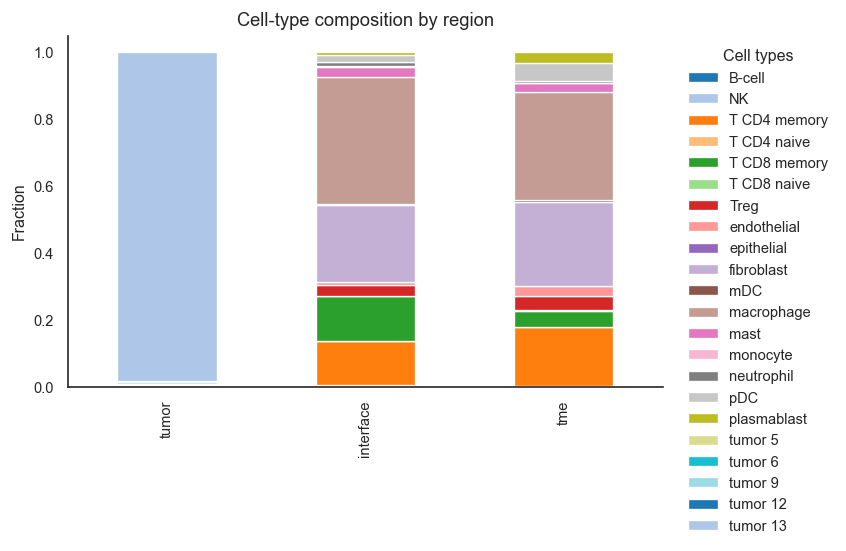

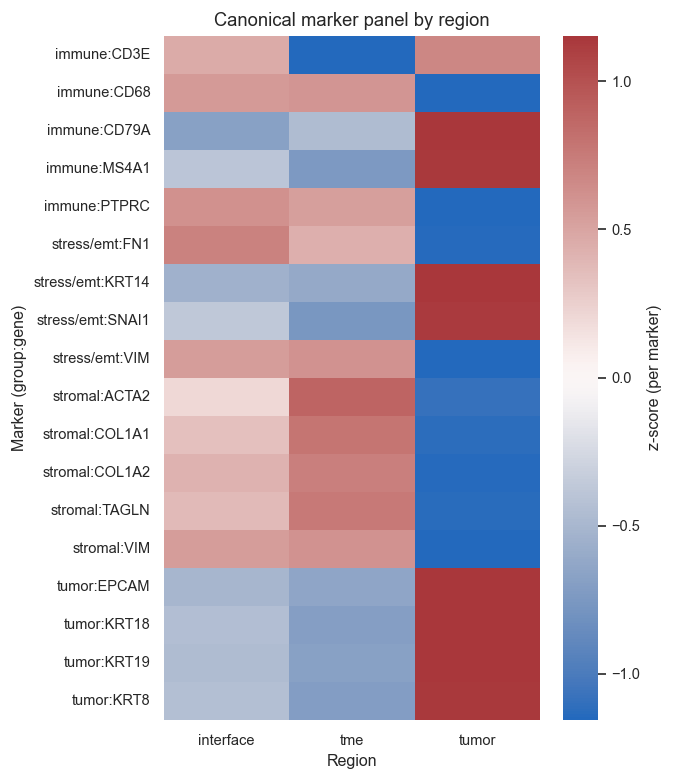

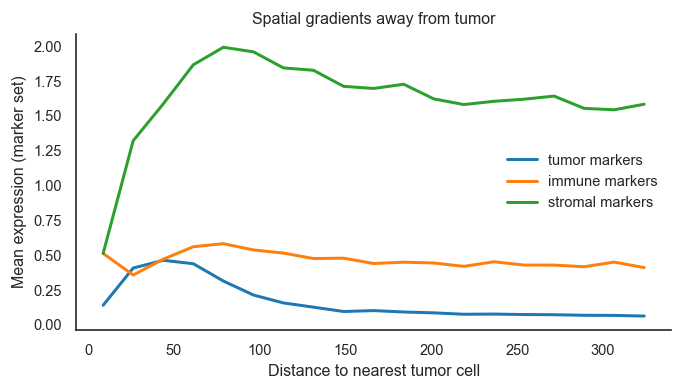

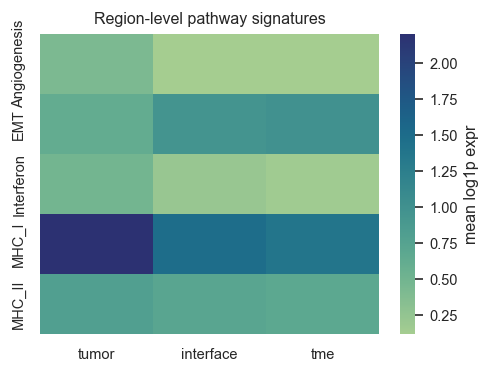

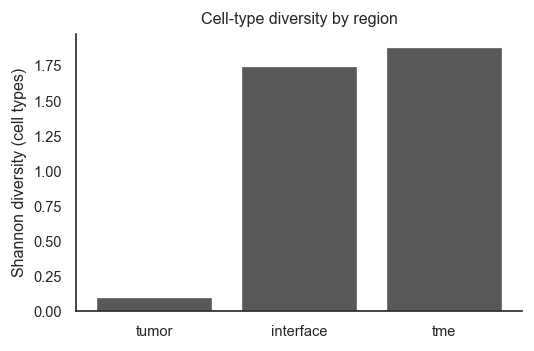

[done] Figures & tables saved to: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures


In [13]:
# =========================
# Tumor–Interface–TME validation (publication/Illustrator ready)
# =========================
import os, re, json, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import sparse  # add near your imports


# -----------------------
# CONFIG
# -----------------------
OUTDIR      = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures"
REGION_COL  = "TIS_region"        # change if your column is named differently
CELLTYPE_COL = ("author_cell_type" if "author_cell_type" in adata.obs.columns
                else adata.obs.columns[0])

# Canonical markers (edit to your panel)
MARKERS = {
    "tumor":      ["EPCAM","KRT8","KRT18","MUC1","KRT19"],
    "immune":     ["PTPRC","CD3E","CD79A","MS4A1","CD68"],
    "stromal":    ["COL1A1","COL1A2","ACTA2","TAGLN","VIM"],
    "stress/emt": ["VIM","FN1","SNAI1","ZEB1","KRT14"]
}

# Optional: latent to use for embedding diagnostics
# Try one of these keys if present; set to None to skip PCA-on-latents panels.
LATENT_KEYS_TRY = ["X_sae", "X_latent", "X_scgpt", "X_pca", "X_emb", "X_layer4"]

# -----------------------
# Illustrator-friendly style (editable text in PDFs/SVGs)
# -----------------------
BASE = 12  # master font size
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,           # TrueType text, not outlines
    "ps.fonttype": 42,
})
sns.set_context("paper")
sns.set_style("white")

os.makedirs(OUTDIR, exist_ok=True)

def _sv(name):  # save vector: both pdf & svg
    plt.savefig(os.path.join(OUTDIR, f"{name}.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(OUTDIR, f"{name}.svg"), bbox_inches="tight")

# -----------------------
# Utilities
# -----------------------
def _ensure_spatial(adata):
    key = None
    for k in ("spatial","X_spatial","spatial_coords"):
        if k in adata.obsm: key = k; break
    if key is None:
        raise KeyError("No spatial coordinates found in adata.obsm (tried 'spatial', 'X_spatial', 'spatial_coords').")
    return key

def _pick_latent_key(adata, candidates):
    for k in candidates:
        if k in adata.obsm:
            return k
    return None

def _mean_by_group(mat, groups):
    # mat: n_cells x n_features (dense or sparse)
    # groups: pandas Series aligned with rows
    df = pd.DataFrame(mat if not hasattr(mat, "A") else mat.A)
    df["_grp"] = groups.values
    mu = df.groupby("_grp").mean()
    mu.index.name = "region"
    return mu

def _get_var_index(adata):
    if "index" in adata.var.columns:
        return adata.var["index"].astype(str).values
    return adata.var_names.astype(str).values

def _gene_slice(adata, gene_list):
    varnames = _get_var_index(adata)
    mask = np.isin(varnames, np.array(gene_list, dtype=str))
    return adata[:, mask], varnames[mask]

# -----------------------
# A) Region composition (colorful) & marker validation (transposed)
# -----------------------
def figA_region_composition(adata, region_col, celltype_col, palette_ct=None):
    df = adata.obs[[region_col, celltype_col]].copy()
    order = ["tumor", "interface", "tme"]
    order = [o for o in order if o in df[region_col].unique()]

    comp = (df.value_counts([region_col, celltype_col])
              .rename("n")
              .reset_index()
              .assign(frac=lambda d: d.groupby(region_col)["n"]
                                      .transform(lambda x: x/x.sum())))
    pivot = comp.pivot(index=region_col, columns=celltype_col, values="frac").fillna(0.0).loc[order]

    # --- color palette helper (your version)
    def _make_palette(vals, palette=None, gray_default="0.7"):
        uniq = pd.Index(pd.Series(vals).unique())
        if palette is None:
            pal = {u: plt.cm.tab20(i % 20) for i, u in enumerate(uniq)}
        else:
            pal = palette
        return np.array([pal.get(v, gray_default) for v in vals], dtype=object), pal

    ct_colors, ct_pal = _make_palette(pivot.columns, palette_ct)

    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    pivot.plot(kind="bar", stacked=True, ax=ax,
               color=[ct_pal[c] for c in pivot.columns])
    ax.set_ylabel("Fraction")
    ax.set_xlabel("")
    ax.set_title("Cell-type composition by region", fontsize=11)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left",
              frameon=False, ncol=1, title="Cell types")
    sns.despine()
    _sv("A1_region_composition_colored")
    plt.show()

    return pivot


# -----------------------
# B) Canonical marker validation (transposed heatmap)
# -----------------------
def figB_marker_validation(adata, region_col, markers):
    order = ["tumor", "interface", "tme"]
    order = [o for o in order if o in adata.obs[region_col].unique()]

    rows = []
    varnames = _get_var_index(adata)
    for group, genes in markers.items():
        keep = [g for g in genes if g in varnames]
        if not keep:
            continue
        Xslice, gkept = _gene_slice(adata, keep)
        mu = _mean_by_group(Xslice.X, adata.obs[region_col])
        mu = np.array(mu.loc[order, :])  # regions × genes
        for i, r in enumerate(order):
            for j, g in enumerate(gkept):
                rows.append((r, f"{group}:{g}", float(mu[i, j])))

    mdf = (pd.DataFrame(rows, columns=["region", "marker", "mean_expr"])
             .pivot(index="region", columns="marker", values="mean_expr")
             .fillna(0))
    mdf_z = (mdf - mdf.mean(0)) / (mdf.std(0) + 1e-12)
    mdf_z_T = mdf_z.T  # transpose for readability

    plt.figure(figsize=(0.35 * len(order) + 4, 0.3 * mdf_z_T.shape[0] + 2))
    sns.heatmap(
        mdf_z_T,
        cmap="vlag",
        center=0.0,
        cbar_kws={"label": "z-score (per marker)"},
        yticklabels=True,
        xticklabels=True
    )
    plt.title("Canonical marker panel by region", fontsize=11)
    plt.xlabel("Region")
    plt.ylabel("Marker (group:gene)")
    sns.despine(left=True, bottom=True)
    _sv("B1_marker_panel_transposed")
    plt.show()

    # Save the data table
    mdf_z_T.to_csv(os.path.join(OUTDIR, "B1_marker_panel_zscore_transposed.csv"))
    return mdf_z_T

# -----------------------
# C) Spatial gradient vs distance to tumor
# -----------------------
def figC_spatial_gradients(adata, region_col, markers):
    spat_key = _ensure_spatial(adata)
    XY = np.asarray(adata.obsm[spat_key])
    is_tumor = (adata.obs[region_col].astype(str).str.lower()=="tumor").values
    if is_tumor.sum() == 0:
        warnings.warn("No tumor cells in region labels; skipping distance gradients.")
        return None
    tree = cKDTree(XY[is_tumor])
    dists, _ = tree.query(XY, k=1)
    # pick a few marker summaries to show gradient
    panels = {
        "tumor_markers" : [g for g in MARKERS["tumor"] if g in _get_var_index(adata)],
        "immune_markers": [g for g in MARKERS["immune"] if g in _get_var_index(adata)],
        "stromal_markers":[g for g in MARKERS["stromal"] if g in _get_var_index(adata)],
    }
    # plot binned mean expression vs distance
    bins = np.linspace(0, np.percentile(dists, 95), 20)
    mids = 0.5*(bins[1:]+bins[:-1])
    plt.figure(figsize=(6.4,3.2))
    for name, genes in panels.items():
        if not genes: continue
        Xi, _ = _gene_slice(adata, genes)
        mu = np.asarray(Xi.X.mean(axis=1)).ravel() if hasattr(Xi.X, "A") else Xi.X.mean(axis=1)
        bmean = pd.Series(mu).groupby(pd.cut(dists, bins)).mean().values
        plt.plot(mids, bmean, label=name.replace("_"," "), lw=1.8)
    plt.xlabel("Distance to nearest tumor cell")
    plt.ylabel("Mean expression (marker set)")
    plt.title("Spatial gradients away from tumor")
    plt.legend(frameon=False)
    sns.despine()
    _sv("C1_spatial_gradients"); plt.show()
    # also save the distances vector for downstream
    np.save(os.path.join(OUTDIR, "C2_cell_to_tumor_distance.npy"), dists)
    return dists

# -----------------------
# D) Region-level pathway signatures (simple set means)
# -----------------------
def figD_pathway_signatures(adata, region_col, gene_sets_dict):
    """
    gene_sets_dict: {"name": [genes, ...], ...}
    Computes mean(log1p) per set × region and shows heatmap.
    """
    varnames = _get_var_index(adata)
    order = [x for x in ["tumor","interface","tme"] if x in adata.obs[region_col].unique()]
    rows = []
    for name, genes in gene_sets_dict.items():
        keep = [g for g in genes if g in varnames]
        if not keep: 
            continue
        X, _ = _gene_slice(adata, keep)
        # log1p mean per cell then region mean
        cell_mean = np.asarray(X.X.mean(axis=1)).ravel() if hasattr(X.X, "A") else X.X.mean(axis=1)
        tmp = pd.DataFrame({"region": adata.obs[region_col].values, "cell_score": np.log1p(cell_mean)})
        agg = tmp.groupby("region")["cell_score"].mean()
        for r in order:
            rows.append((name, r, float(agg.get(r, np.nan))))
    if not rows:
        warnings.warn("No gene sets overlapped with var names; skipping D.")
        return None
    df = (
        pd.DataFrame(rows, columns=["set", "region", "score"])
        .pivot(index="set", columns="region", values="score")
        .loc[:, order]
    )
    plt.figure(figsize=(3.6 + 0.32*df.shape[1], 0.35*df.shape[0] + 1.5))
    sns.heatmap(df, cmap="crest", cbar_kws={"label":"mean log1p expr"})
    plt.title("Region-level pathway signatures")
    plt.xlabel("")
    plt.ylabel("")
    _sv("D1_pathway_signatures"); plt.show()
    df.to_csv(os.path.join(OUTDIR, "D1_pathway_signatures.csv"))
    return df

# -----------------------
# E) Diversity & heterogeneity metrics
# -----------------------
def figE_diversity_metrics(adata, region_col, celltype_col):
    # Shannon diversity of cell types per region
    df = adata.obs[[region_col, celltype_col]].copy()
    order = [x for x in ["tumor","interface","tme"] if x in df[region_col].unique()]
    rows = []
    for r, sub in df.groupby(region_col):
        p = sub[celltype_col].value_counts(normalize=True).values
        H = -np.sum(p * np.log(p + 1e-12))
        rows.append((r, H, sub.shape[0]))
    met = pd.DataFrame(rows, columns=["region","shannon_celltype","n_cells"]).set_index("region").loc[order]
    fig, ax1 = plt.subplots(figsize=(4.8,3.0))
    ax1.bar(met.index, met["shannon_celltype"], color="0.35")
    ax1.set_ylabel("Shannon diversity (cell types)")
    ax1.set_xlabel("")
    ax1.set_title("Cell-type diversity by region")
    sns.despine()
    _sv("E1_celltype_diversity"); plt.show()
    met.to_csv(os.path.join(OUTDIR, "E1_celltype_diversity.csv"))
    return met

# -----------------------
# RUN ALL
# -----------------------
print("[TIS] Using obs columns:", dict(region=REGION_COL, celltype=CELLTYPE_COL))

# A) composition (colored) + B) marker validation (transposed)
figA_region_composition(adata, REGION_COL, CELLTYPE_COL)
figB_marker_validation(adata, REGION_COL, MARKERS)

# C–E unchanged
figC_spatial_gradients(adata, REGION_COL, MARKERS)

PATHWAY_SETS = {
    "EMT"          : ["VIM","FN1","COL1A1","COL3A1","SNAI1","ZEB1"],
    "Interferon"   : ["IFIT1","IFIT3","ISG15","STAT1","IRF7"],
    "Angiogenesis" : ["KDR","FLT1","ENG","PECAM1","VEGFA"],
    "MHC_I"        : ["HLA-A","HLA-B","HLA-C","B2M"],
    "MHC_II"       : ["HLA-DRA","HLA-DRB1","HLA-DPA1","HLA-DPB1"],
}
figD_pathway_signatures(adata, REGION_COL, PATHWAY_SETS)
figE_diversity_metrics(adata, REGION_COL, CELLTYPE_COL)

print(f"[done] Figures & tables saved to: {OUTDIR}")

[TIS] Using obs columns: {'region': 'TIS_region', 'celltype': 'author_cell_type'}


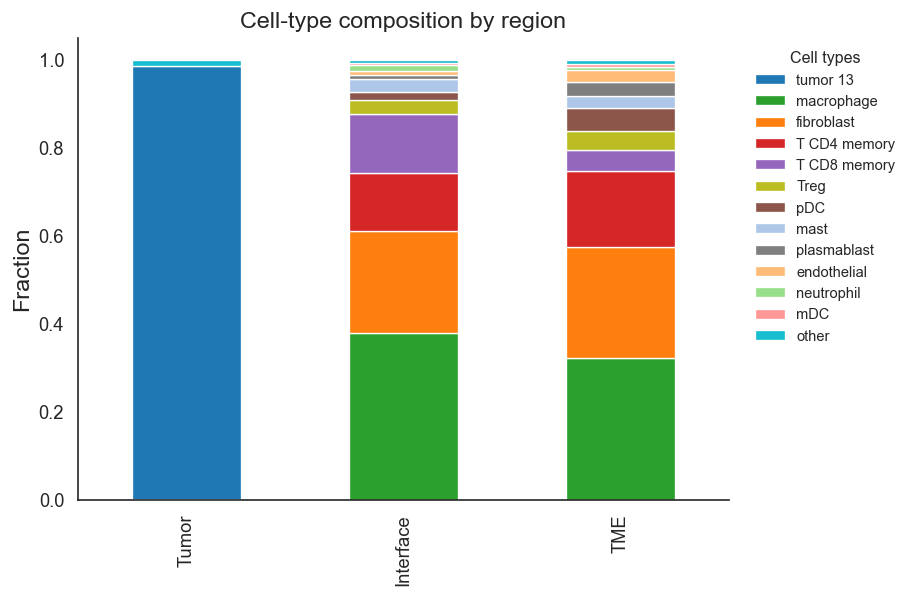

author_cell_type,tumor 13,macrophage,fibroblast,T CD4 memory,T CD8 memory,Treg,pDC,mast,plasmablast,endothelial,neutrophil,mDC,other
TIS_region,,,,,,,,,,,,,
tumor,0.984381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015619
interface,0.000000,0.379380,0.230292,0.132482,0.134307,0.030839,0.018796,0.028832,0.009307,0.010036,0.014051,0.004745,0.006934
tme,0.000000,0.322633,0.250380,0.174761,0.047269,0.042078,0.052704,0.026950,0.032182,0.028268,0.006793,0.006327,0.009653


In [12]:
# =========================
# Tumor–Interface–TME validation (publication/Illustrator ready)
# =========================
import os, re, json, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# -----------------------
# CONFIG
# -----------------------
OUTDIR      = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures"
REGION_COL  = "TIS_region"        # change if your column is named differently
CELLTYPE_COL = ("author_cell_type" if "author_cell_type" in adata.obs.columns
                else adata.obs.columns[0])

MARKERS = {
    "tumor":      ["EPCAM","KRT8","KRT18","MUC1","KRT19"],
    "immune":     ["PTPRC","CD3E","CD79A","MS4A1","CD68"],
    "stromal":    ["COL1A1","COL1A2","ACTA2","TAGLN","VIM"],
    "stress/emt": ["VIM","FN1","SNAI1","ZEB1","KRT14"]
}

LATENT_KEYS_TRY = ["X_sae", "X_latent", "X_scgpt", "X_pca", "X_emb", "X_layer4"]

# ---------- unified palettes ----------
PALETTE_COMP = {  # match your spatial overview
    "tme":       "#f3b6b6",  # soft pink
    "tumor":     "#b7c9f2",  # light blue
    "interface": "#f2e3a5",  # pale yellow
}
# -----------------------
# Illustrator-friendly style
# -----------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
sns.set_context("paper"); sns.set_style("white")
os.makedirs(OUTDIR, exist_ok=True)

def _sv(name):  # save vector: both pdf & svg
    plt.savefig(os.path.join(OUTDIR, f"{name}.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(OUTDIR, f"{name}.svg"), bbox_inches="tight")

# -----------------------
# Utilities
# -----------------------
def _ensure_spatial(adata):
    for k in ("spatial","X_spatial","spatial_coords"):
        if k in adata.obsm: return k
    raise KeyError("No spatial coordinates found in adata.obsm (tried 'spatial', 'X_spatial', 'spatial_coords').")

def _pick_latent_key(adata, candidates):
    for k in candidates:
        if k in adata.obsm: return k
    return None

def _mean_by_group(mat, groups):
    df = pd.DataFrame(mat if not hasattr(mat, "A") else mat.A)
    df["_grp"] = groups.values
    mu = df.groupby("_grp").mean()
    mu.index.name = "region"
    return mu

def _get_var_index(adata):
    return (adata.var["index"].astype(str).values
            if "index" in adata.var.columns else adata.var_names.astype(str).values)

def _gene_slice(adata, gene_list):
    varnames = _get_var_index(adata)
    mask = np.isin(varnames, np.array(gene_list, dtype=str))
    return adata[:, mask], varnames[mask]

# -----------------------
# A) Region composition (colorful)
# -----------------------
PALETTE_CT = {
    "tumor 13":    "#1f77b4",
    "macrophage":  "#2ca02c",
    "fibroblast":  "#ff7f0e",
    "T CD4 memory":"#d62728",
    "T CD8 memory":"#9467bd",
    "pDC":         "#8c564b",
    "Treg":        "#bcbd22",
    "plasmablast": "#7f7f7f",
    "other":       "#17becf",
}

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def figA_region_composition(
    adata,
    region_col,
    celltype_col,
    palette_ct=PALETTE_CT,
    top_n=12,
):
    df = adata.obs[[region_col, celltype_col]].copy()
    order = [o for o in ["tumor", "interface", "tme"] if o in df[region_col].unique()]

    comp = (
        df.value_counts([region_col, celltype_col])
          .rename("n").reset_index()
          .assign(frac=lambda d: d.groupby(region_col)["n"].transform(lambda x: x / x.sum()))
    )
    pivot = (
        comp.pivot(index=region_col, columns=celltype_col, values="frac")
            .fillna(0.0)
            .loc[order]
    )

    # ---- rank cell types by mean composition & keep top_n ----
    mean_ct = pivot.mean(axis=0)
    ranked_cts = mean_ct.sort_values(ascending=False).index.tolist()

    top_cts = ranked_cts[:top_n]
    rest_cts = ranked_cts[top_n:]

    pivot_top = pivot[top_cts].copy()
    if len(rest_cts) > 0:
        pivot_top["other"] = pivot[rest_cts].sum(axis=1)
        cols = [c for c in pivot_top.columns if c != "other"] + ["other"]
        pivot_top = pivot_top[cols]

    # ---- colors: use palette_ct, assign new non-redundant tab20 colors ----
    all_cts = list(pivot_top.columns)
    missing_cts = [ct for ct in all_cts if ct not in palette_ct]

    extra_colors = {}
    if missing_cts:
        tab20 = sns.color_palette("tab20", 20)

        # colors already in use (RGBA tuples)
        used = {mpl.colors.to_rgba(c) for c in palette_ct.values()}

        # pick tab20 colors that are not already used
        available = [c for c in tab20 if mpl.colors.to_rgba(c) not in used]
        assert len(available) >= len(missing_cts), "Not enough distinct colors available."

        extra_colors = {ct: available[i] for i, ct in enumerate(missing_cts)}

    ct_cols = []
    for ct in all_cts:
        if ct in palette_ct:
            ct_cols.append(palette_ct[ct])
        else:
            ct_cols.append(extra_colors[ct])

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(7, 5))
    pivot_top.plot(kind="bar", stacked=True, ax=ax, color=ct_cols)

    ax.set_ylabel("Fraction", fontsize=14)
    ax.set_xlabel("")
    ax.set_title("Cell-type composition by region", fontsize=14)

    ax.tick_params(axis="both", labelsize=11)

    label_map = {"tumor": "Tumor", "interface": "Interface", "tme": "TME"}
    new_xticks = [label_map.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()]
    ax.set_xticklabels(new_xticks)

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
        ncol=1,
        title="Cell types",
    )

    sns.despine()
    _sv("A1_region_composition_colored")
    plt.show()

    return pivot_top

print("[TIS] Using obs columns:", dict(region=REGION_COL, celltype=CELLTYPE_COL))
figA_region_composition(adata, REGION_COL, CELLTYPE_COL)      # A (colored)

In [ ]:
# =========================
# Tumor–Interface–TME validation (publication/Illustrator ready)
# =========================
import os, re, json, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# -----------------------
# CONFIG
# -----------------------
OUTDIR      = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures"
REGION_COL  = "TIS_region"        # change if your column is named differently
CELLTYPE_COL = ("author_cell_type" if "author_cell_type" in adata.obs.columns
                else adata.obs.columns[0])

MARKERS = {
    "tumor":      ["EPCAM","KRT8","KRT18","MUC1","KRT19"],
    "immune":     ["PTPRC","CD3E","CD79A","MS4A1","CD68"],
    "stromal":    ["COL1A1","COL1A2","ACTA2","TAGLN","VIM"],
    "stress/emt": ["VIM","FN1","SNAI1","ZEB1","KRT14"]
}

LATENT_KEYS_TRY = ["X_sae", "X_latent", "X_scgpt", "X_pca", "X_emb", "X_layer4"]

# ---------- unified palettes ----------
PALETTE_COMP = {  # match your spatial overview
    "tme":       "#f3b6b6",  # soft pink
    "tumor":     "#b7c9f2",  # light blue
    "interface": "#f2e3a5",  # pale yellow
}
PALETTE_CT = {     # plug your exact CT colors here; fall back handled below
    "tumor 13":    "#1f77b4",
    "macrophage":  "#2ca02c",
    "fibroblast":  "#ff7f0e",
    "T CD4 memory":"#d62728",
    "T CD8 memory":"#9467bd",
    "pDC":         "#8c564b",
    "Treg":        "#bcbd22",
    "plasmablast": "#7f7f7f",
    "other":       "#17becf",
}

# -----------------------
# Illustrator-friendly style
# -----------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
sns.set_context("paper"); sns.set_style("white")
os.makedirs(OUTDIR, exist_ok=True)

def _sv(name):  # save vector: both pdf & svg
    plt.savefig(os.path.join(OUTDIR, f"{name}.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(OUTDIR, f"{name}.svg"), bbox_inches="tight")

# -----------------------
# Utilities
# -----------------------
def _ensure_spatial(adata):
    for k in ("spatial","X_spatial","spatial_coords"):
        if k in adata.obsm: return k
    raise KeyError("No spatial coordinates found in adata.obsm (tried 'spatial', 'X_spatial', 'spatial_coords').")

def _pick_latent_key(adata, candidates):
    for k in candidates:
        if k in adata.obsm: return k
    return None

def _mean_by_group(mat, groups):
    df = pd.DataFrame(mat if not hasattr(mat, "A") else mat.A)
    df["_grp"] = groups.values
    mu = df.groupby("_grp").mean()
    mu.index.name = "region"
    return mu

def _get_var_index(adata):
    return (adata.var["index"].astype(str).values
            if "index" in adata.var.columns else adata.var_names.astype(str).values)

def _gene_slice(adata, gene_list):
    varnames = _get_var_index(adata)
    mask = np.isin(varnames, np.array(gene_list, dtype=str))
    return adata[:, mask], varnames[mask]

# -----------------------
# A) Region composition (colorful)
# -----------------------
# def figA_region_composition(adata, region_col, celltype_col, palette_ct=PALETTE_CT):
#     df = adata.obs[[region_col, celltype_col]].copy()
#     order = [o for o in ["tumor","interface","tme"] if o in df[region_col].unique()]

#     comp = (df.value_counts([region_col, celltype_col])
#               .rename("n").reset_index()
#               .assign(frac=lambda d: d.groupby(region_col)["n"].transform(lambda x: x/x.sum())))
#     pivot = comp.pivot(index=region_col, columns=celltype_col, values="frac").fillna(0.0).loc[order]

#     # colors aligned to your CT palette (fallback to tab20)
#     ct_cols = []
#     tab20 = sns.color_palette("tab20", 20)
#     for ct in pivot.columns:
#         key = str(ct)
#         ct_cols.append(palette_ct.get(key, tab20[hash(key) % 20]))

#     fig, ax = plt.subplots(figsize=(6.4, 3.8))
#     pivot.plot(kind="bar", stacked=True, ax=ax, color=ct_cols)
#     ax.set_ylabel("Fraction"); ax.set_xlabel("")
#     ax.set_title("Cell-type composition by region", fontsize=11)
#     ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, ncol=1, title="Cell types")
#     sns.despine()
#     _sv("A1_region_composition_colored"); plt.show()
#     return pivot

# -----------------------
# B) Canonical marker validation (transposed heatmap)
# -----------------------
def figB_marker_validation(adata, region_col, markers):
    order = [o for o in ["tumor","interface","tme"] if o in adata.obs[region_col].unique()]
    rows, varnames = [], _get_var_index(adata)

    for group, genes in markers.items():
        keep = [g for g in genes if g in varnames]
        if not keep: continue
        Xslice, gkept = _gene_slice(adata, keep)
        mu = _mean_by_group(Xslice.X, adata.obs[region_col])
        mu = np.array(mu.loc[order, :])  # regions × genes
        for i, r in enumerate(order):
            for j, g in enumerate(gkept):
                rows.append((r, f"{group}:{g}", float(mu[i, j])))

    mdf = (pd.DataFrame(rows, columns=["region","marker","mean_expr"])
             .pivot(index="region", columns="marker", values="mean_expr").fillna(0))
    mdf_z = (mdf - mdf.mean(0)) / (mdf.std(0) + 1e-12)
    mdf_z_T = mdf_z.T  # rows: markers, cols: regions

    plt.figure(figsize=(0.35 * len(order) + 4, 0.3 * mdf_z_T.shape[0] + 2))
    sns.heatmap(mdf_z_T, cmap="vlag", center=0.0,
                cbar_kws={"label": "z-score (per marker)"},
                yticklabels=True, xticklabels=True)
    plt.title("Canonical marker panel by region", fontsize=11)
    plt.xlabel("Region"); plt.ylabel("Marker (group:gene)")
    sns.despine(left=True, bottom=True)
    _sv("B1_marker_panel_transposed"); plt.show()

    mdf_z_T.to_csv(os.path.join(OUTDIR, "B1_marker_panel_zscore_transposed.csv"))
    return mdf_z_T

# -----------------------
# C) Spatial gradient vs distance to tumor (compartment colors)
# -----------------------
def figC_spatial_gradients(adata, region_col, markers):
    spat_key = _ensure_spatial(adata)
    XY = np.asarray(adata.obsm[spat_key])
    is_tumor = (adata.obs[region_col].astype(str).str.lower()=="tumor").values
    if is_tumor.sum() == 0:
        warnings.warn("No tumor cells in region labels; skipping distance gradients.")
        return None

    tree = cKDTree(XY[is_tumor])
    dists, _ = tree.query(XY, k=1)

    panels = {
        "tumor_markers" : [g for g in MARKERS["tumor"] if g in _get_var_index(adata)],
        "immune_markers": [g for g in MARKERS["immune"] if g in _get_var_index(adata)],
        "stromal_markers":[g for g in MARKERS["stromal"] if g in _get_var_index(adata)],
    }
    name_to_comp = {"tumor_markers":"tumor", "immune_markers":"tme", "stromal_markers":"interface"}

    bins = np.linspace(0, np.percentile(dists, 95), 20)
    mids = 0.5*(bins[1:]+bins[:-1])

    plt.figure(figsize=(6.4,3.2))
    for name, genes in panels.items():
        if not genes: continue
        color = PALETTE_COMP.get(name_to_comp.get(name, "tme"), "0.3")
        Xi, _ = _gene_slice(adata, genes)
        mu = (np.asarray(Xi.X.mean(axis=1)).ravel()
              if hasattr(Xi.X, "A") else np.asarray(Xi.X.mean(axis=1)).ravel())
        bmean = pd.Series(mu).groupby(pd.cut(dists, bins)).mean().values
        plt.plot(mids, bmean, label=name.replace("_"," "), lw=1.8, color=color)

    plt.xlabel("Distance to nearest tumor cell")
    plt.ylabel("Mean expression (marker set)")
    plt.title("Spatial gradients away from tumor")
    plt.legend(frameon=False); sns.despine()
    _sv("C1_spatial_gradients"); plt.show()

    np.save(os.path.join(OUTDIR, "C2_cell_to_tumor_distance.npy"), dists)
    return dists

# -----------------------
# D) Region-level pathway signatures (match Fig B style)
# -----------------------
def figD_pathway_signatures(adata, region_col, gene_sets_dict):
    varnames = _get_var_index(adata)
    order = [x for x in ["tumor","interface","tme"] if x in adata.obs[region_col].unique()]
    rows = []

    for name, genes in gene_sets_dict.items():
        keep = [g for g in genes if g in varnames]
        if not keep: continue
        X, _ = _gene_slice(adata, keep)
        cell_mean = (np.asarray(X.X.mean(axis=1)).ravel()
                     if hasattr(X.X, "A") else np.asarray(X.X.mean(axis=1)).ravel())
        tmp = pd.DataFrame({"region": adata.obs[region_col].values,
                            "cell_score": np.log1p(cell_mean)})
        agg = tmp.groupby("region")["cell_score"].mean()
        for r in order:
            rows.append((name, r, float(agg.get(r, np.nan))))

    if not rows:
        warnings.warn("No gene sets overlapped with var names; skipping D.")
        return None

    df_raw = (pd.DataFrame(rows, columns=["set","region","score"])
                .pivot(index="set", columns="region", values="score")
                .reindex(columns=order))

    # z-score per set to match Fig B heatmap style
    df = (df_raw.sub(df_raw.mean(axis=1), axis=0)
                 .div(df_raw.std(axis=1).replace(0, np.nan), axis=0))

    plt.figure(figsize=(3.6 + 0.32*df.shape[1], 0.35*df.shape[0] + 1.5))
    sns.heatmap(df, cmap="vlag", center=0.0,
                cbar_kws={"label":"z-score (per pathway set)"})
    plt.title("Region-level pathway signatures"); plt.xlabel(""); plt.ylabel("")
    _sv("D1_pathway_signatures"); plt.show()

    df_raw.to_csv(os.path.join(OUTDIR, "D1_pathway_signatures_raw.csv"))
    df.to_csv(os.path.join(OUTDIR, "D1_pathway_signatures_zscored.csv"))
    return df

# -----------------------
# E) Diversity & heterogeneity metrics
# -----------------------
def figE_diversity_metrics(adata, region_col, celltype_col):
    df = adata.obs[[region_col, celltype_col]].copy()
    order = [x for x in ["tumor","interface","tme"] if x in df[region_col].unique()]
    rows = []
    for r, sub in df.groupby(region_col):
        p = sub[celltype_col].value_counts(normalize=True).values
        H = -np.sum(p * np.log(p + 1e-12))
        rows.append((r, H, sub.shape[0]))
    met = (pd.DataFrame(rows, columns=["region","shannon_celltype","n_cells"])
             .set_index("region").loc[order])

    fig, ax1 = plt.subplots(figsize=(4.8,3.0))
    ax1.bar(met.index, met["shannon_celltype"], color="0.35")
    ax1.set_ylabel("Shannon diversity (cell types)")
    ax1.set_xlabel(""); ax1.set_title("Cell-type diversity by region")
    sns.despine(); _sv("E1_celltype_diversity"); plt.show()
    met.to_csv(os.path.join(OUTDIR, "E1_celltype_diversity.csv"))
    return met

# -----------------------
# RUN ALL
# -----------------------
print("[TIS] Using obs columns:", dict(region=REGION_COL, celltype=CELLTYPE_COL))
figA_region_composition(adata, REGION_COL, CELLTYPE_COL)      # A (colored)
figB_marker_validation(adata, REGION_COL, MARKERS)            # B (transposed)
figC_spatial_gradients(adata, REGION_COL, MARKERS)            # C (comp colors)

PATHWAY_SETS = {
    "EMT"          : ["VIM","FN1","COL1A1","COL3A1","SNAI1","ZEB1"],
    "Interferon"   : ["IFIT1","IFIT3","ISG15","STAT1","IRF7"],
    "Angiogenesis" : ["KDR","FLT1","ENG","PECAM1","VEGFA"],
    "MHC_I"        : ["HLA-A","HLA-B","HLA-C","B2M"],
    "MHC_II"       : ["HLA-DRA","HLA-DRB1","HLA-DPA1","HLA-DPB1"],
}
figD_pathway_signatures(adata, REGION_COL, PATHWAY_SETS)      # D (match B)
figE_diversity_metrics(adata, REGION_COL, CELLTYPE_COL)       # E

print(f"[done] Figures & tables saved to: {OUTDIR}")

[TIS] Using obs columns: {'region': 'TIS_region', 'celltype': 'author_cell_type'}


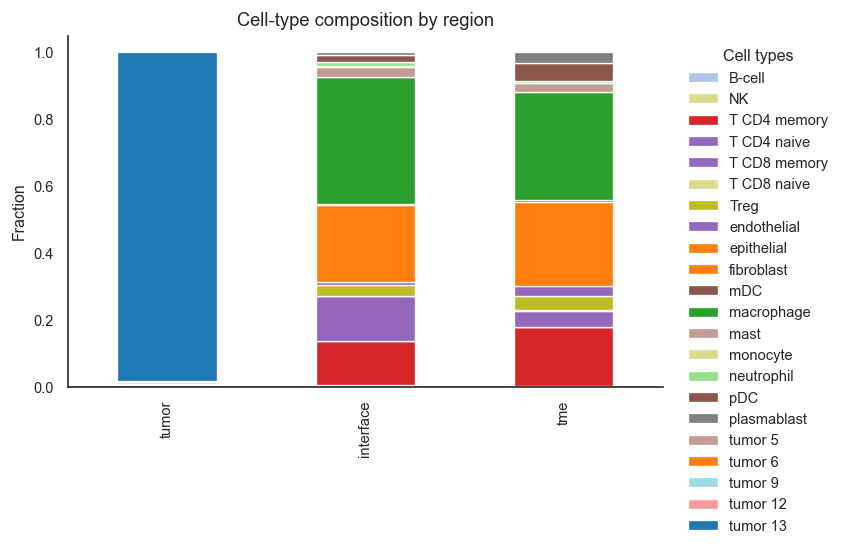

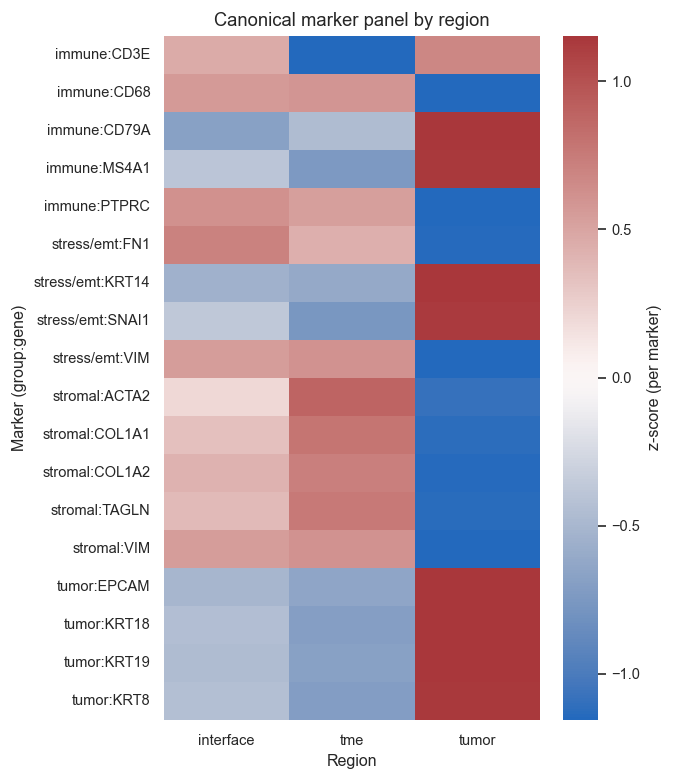

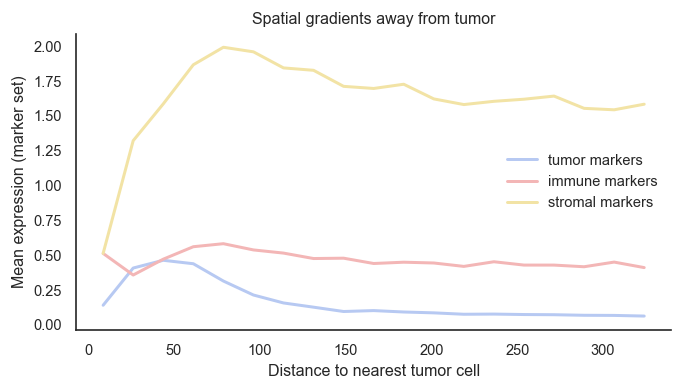

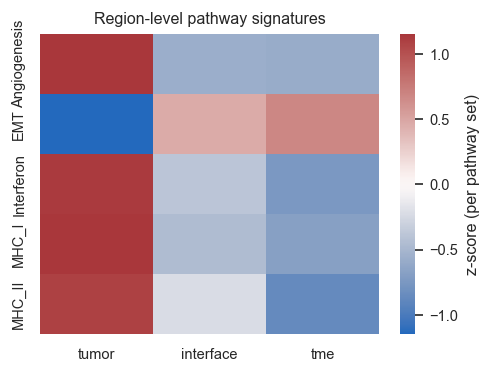

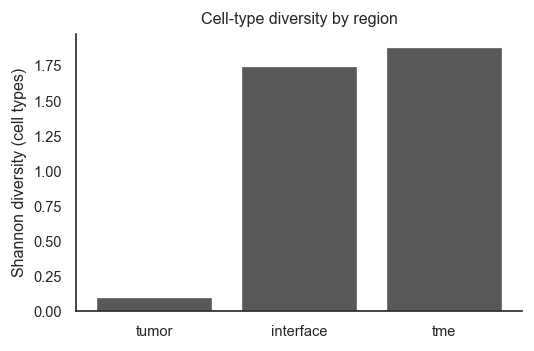

[done] Figures & tables saved to: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures


In [15]:
# =========================
# Tumor–Interface–TME validation (publication/Illustrator ready)
# =========================
import os, re, json, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# -----------------------
# CONFIG
# -----------------------
OUTDIR      = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/TIS/finalized/figures"
REGION_COL  = "TIS_region"        # change if your column is named differently
CELLTYPE_COL = ("author_cell_type" if "author_cell_type" in adata.obs.columns
                else adata.obs.columns[0])

MARKERS = {
    "tumor":      ["EPCAM","KRT8","KRT18","MUC1","KRT19"],
    "immune":     ["PTPRC","CD3E","CD79A","MS4A1","CD68"],
    "stromal":    ["COL1A1","COL1A2","ACTA2","TAGLN","VIM"],
    "stress/emt": ["VIM","FN1","SNAI1","ZEB1","KRT14"]
}

LATENT_KEYS_TRY = ["X_sae", "X_latent", "X_scgpt", "X_pca", "X_emb", "X_layer4"]

# ---------- unified palettes ----------
PALETTE_COMP = {  # match your spatial overview
    "tme":       "#f3b6b6",  # soft pink
    "tumor":     "#b7c9f2",  # light blue
    "interface": "#f2e3a5",  # pale yellow
}
PALETTE_CT = {     # plug your exact CT colors here; fall back handled below
    "tumor 13":    "#1f77b4",
    "macrophage":  "#2ca02c",
    "fibroblast":  "#ff7f0e",
    "T CD4 memory":"#d62728",
    "T CD8 memory":"#9467bd",
    "pDC":         "#8c564b",
    "Treg":        "#bcbd22",
    "plasmablast": "#7f7f7f",
    "other":       "#17becf",
}

# -----------------------
# Illustrator-friendly style
# -----------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
sns.set_context("paper"); sns.set_style("white")
os.makedirs(OUTDIR, exist_ok=True)

def _sv(name):  # save vector: both pdf & svg
    plt.savefig(os.path.join(OUTDIR, f"{name}.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(OUTDIR, f"{name}.svg"), bbox_inches="tight")

# -----------------------
# Utilities
# -----------------------
def _ensure_spatial(adata):
    for k in ("spatial","X_spatial","spatial_coords"):
        if k in adata.obsm: return k
    raise KeyError("No spatial coordinates found in adata.obsm (tried 'spatial', 'X_spatial', 'spatial_coords').")

def _pick_latent_key(adata, candidates):
    for k in candidates:
        if k in adata.obsm: return k
    return None

def _mean_by_group(mat, groups):
    df = pd.DataFrame(mat if not hasattr(mat, "A") else mat.A)
    df["_grp"] = groups.values
    mu = df.groupby("_grp").mean()
    mu.index.name = "region"
    return mu

def _get_var_index(adata):
    return (adata.var["index"].astype(str).values
            if "index" in adata.var.columns else adata.var_names.astype(str).values)

def _gene_slice(adata, gene_list):
    varnames = _get_var_index(adata)
    mask = np.isin(varnames, np.array(gene_list, dtype=str))
    return adata[:, mask], varnames[mask]

# -----------------------
# A) Region composition (colorful)
# -----------------------
def figA_region_composition(adata, region_col, celltype_col, palette_ct=PALETTE_CT):
    df = adata.obs[[region_col, celltype_col]].copy()
    order = [o for o in ["tumor","interface","tme"] if o in df[region_col].unique()]

    comp = (df.value_counts([region_col, celltype_col])
              .rename("n").reset_index()
              .assign(frac=lambda d: d.groupby(region_col)["n"].transform(lambda x: x/x.sum())))
    pivot = comp.pivot(index=region_col, columns=celltype_col, values="frac").fillna(0.0).loc[order]

    # colors aligned to your CT palette (fallback to tab20)
    ct_cols = []
    tab20 = sns.color_palette("tab20", 20)
    for ct in pivot.columns:
        key = str(ct)
        ct_cols.append(palette_ct.get(key, tab20[hash(key) % 20]))

    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    pivot.plot(kind="bar", stacked=True, ax=ax, color=ct_cols)
    ax.set_ylabel("Fraction"); ax.set_xlabel("")
    ax.set_title("Cell-type composition by region", fontsize=11)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, ncol=1, title="Cell types")
    sns.despine()
    _sv("A1_region_composition_colored"); plt.show()
    return pivot

# -----------------------
# B) Canonical marker validation (transposed heatmap)
# -----------------------
def figB_marker_validation(adata, region_col, markers):
    order = [o for o in ["tumor","interface","tme"] if o in adata.obs[region_col].unique()]
    rows, varnames = [], _get_var_index(adata)

    for group, genes in markers.items():
        keep = [g for g in genes if g in varnames]
        if not keep: continue
        Xslice, gkept = _gene_slice(adata, keep)
        mu = _mean_by_group(Xslice.X, adata.obs[region_col])
        mu = np.array(mu.loc[order, :])  # regions × genes
        for i, r in enumerate(order):
            for j, g in enumerate(gkept):
                rows.append((r, f"{group}:{g}", float(mu[i, j])))

    mdf = (pd.DataFrame(rows, columns=["region","marker","mean_expr"])
             .pivot(index="region", columns="marker", values="mean_expr").fillna(0))
    mdf_z = (mdf - mdf.mean(0)) / (mdf.std(0) + 1e-12)
    mdf_z_T = mdf_z.T  # rows: markers, cols: regions

    plt.figure(figsize=(0.35 * len(order) + 4, 0.3 * mdf_z_T.shape[0] + 2))
    sns.heatmap(mdf_z_T, cmap="vlag", center=0.0,
                cbar_kws={"label": "z-score (per marker)"},
                yticklabels=True, xticklabels=True)
    plt.title("Canonical marker panel by region", fontsize=11)
    plt.xlabel("Region"); plt.ylabel("Marker (group:gene)")
    sns.despine(left=True, bottom=True)
    _sv("B1_marker_panel_transposed"); plt.show()

    mdf_z_T.to_csv(os.path.join(OUTDIR, "B1_marker_panel_zscore_transposed.csv"))
    return mdf_z_T

# -----------------------
# C) Spatial gradient vs distance to tumor (compartment colors)
# -----------------------
def figC_spatial_gradients(adata, region_col, markers):
    spat_key = _ensure_spatial(adata)
    XY = np.asarray(adata.obsm[spat_key])
    is_tumor = (adata.obs[region_col].astype(str).str.lower()=="tumor").values
    if is_tumor.sum() == 0:
        warnings.warn("No tumor cells in region labels; skipping distance gradients.")
        return None

    tree = cKDTree(XY[is_tumor])
    dists, _ = tree.query(XY, k=1)

    panels = {
        "tumor_markers" : [g for g in MARKERS["tumor"] if g in _get_var_index(adata)],
        "immune_markers": [g for g in MARKERS["immune"] if g in _get_var_index(adata)],
        "stromal_markers":[g for g in MARKERS["stromal"] if g in _get_var_index(adata)],
    }
    name_to_comp = {"tumor_markers":"tumor", "immune_markers":"tme", "stromal_markers":"interface"}

    bins = np.linspace(0, np.percentile(dists, 95), 20)
    mids = 0.5*(bins[1:]+bins[:-1])

    plt.figure(figsize=(6.4,3.2))
    for name, genes in panels.items():
        if not genes: continue
        color = PALETTE_COMP.get(name_to_comp.get(name, "tme"), "0.3")
        Xi, _ = _gene_slice(adata, genes)
        mu = (np.asarray(Xi.X.mean(axis=1)).ravel()
              if hasattr(Xi.X, "A") else np.asarray(Xi.X.mean(axis=1)).ravel())
        bmean = pd.Series(mu).groupby(pd.cut(dists, bins)).mean().values
        plt.plot(mids, bmean, label=name.replace("_"," "), lw=1.8, color=color)

    plt.xlabel("Distance to nearest tumor cell")
    plt.ylabel("Mean expression (marker set)")
    plt.title("Spatial gradients away from tumor")
    plt.legend(frameon=False); sns.despine()
    _sv("C1_spatial_gradients"); plt.show()

    np.save(os.path.join(OUTDIR, "C2_cell_to_tumor_distance.npy"), dists)
    return dists

# -----------------------
# D) Region-level pathway signatures (match Fig B style)
# -----------------------
def figD_pathway_signatures(adata, region_col, gene_sets_dict):
    varnames = _get_var_index(adata)
    order = [x for x in ["tumor","interface","tme"] if x in adata.obs[region_col].unique()]
    rows = []

    for name, genes in gene_sets_dict.items():
        keep = [g for g in genes if g in varnames]
        if not keep: continue
        X, _ = _gene_slice(adata, keep)
        cell_mean = (np.asarray(X.X.mean(axis=1)).ravel()
                     if hasattr(X.X, "A") else np.asarray(X.X.mean(axis=1)).ravel())
        tmp = pd.DataFrame({"region": adata.obs[region_col].values,
                            "cell_score": np.log1p(cell_mean)})
        agg = tmp.groupby("region")["cell_score"].mean()
        for r in order:
            rows.append((name, r, float(agg.get(r, np.nan))))

    if not rows:
        warnings.warn("No gene sets overlapped with var names; skipping D.")
        return None

    df_raw = (pd.DataFrame(rows, columns=["set","region","score"])
                .pivot(index="set", columns="region", values="score")
                .reindex(columns=order))

    # z-score per set to match Fig B heatmap style
    df = (df_raw.sub(df_raw.mean(axis=1), axis=0)
                 .div(df_raw.std(axis=1).replace(0, np.nan), axis=0))

    plt.figure(figsize=(3.6 + 0.32*df.shape[1], 0.35*df.shape[0] + 1.5))
    sns.heatmap(df, cmap="vlag", center=0.0,
                cbar_kws={"label":"z-score (per pathway set)"})
    plt.title("Region-level pathway signatures"); plt.xlabel(""); plt.ylabel("")
    _sv("D1_pathway_signatures"); plt.show()

    df_raw.to_csv(os.path.join(OUTDIR, "D1_pathway_signatures_raw.csv"))
    df.to_csv(os.path.join(OUTDIR, "D1_pathway_signatures_zscored.csv"))
    return df

# -----------------------
# E) Diversity & heterogeneity metrics
# -----------------------
def figE_diversity_metrics(adata, region_col, celltype_col):
    df = adata.obs[[region_col, celltype_col]].copy()
    order = [x for x in ["tumor","interface","tme"] if x in df[region_col].unique()]
    rows = []
    for r, sub in df.groupby(region_col):
        p = sub[celltype_col].value_counts(normalize=True).values
        H = -np.sum(p * np.log(p + 1e-12))
        rows.append((r, H, sub.shape[0]))
    met = (pd.DataFrame(rows, columns=["region","shannon_celltype","n_cells"])
             .set_index("region").loc[order])

    fig, ax1 = plt.subplots(figsize=(4.8,3.0))
    ax1.bar(met.index, met["shannon_celltype"], color="0.35")
    ax1.set_ylabel("Shannon diversity (cell types)")
    ax1.set_xlabel(""); ax1.set_title("Cell-type diversity by region")
    sns.despine(); _sv("E1_celltype_diversity"); plt.show()
    met.to_csv(os.path.join(OUTDIR, "E1_celltype_diversity.csv"))
    return met

# -----------------------
# RUN ALL
# -----------------------
print("[TIS] Using obs columns:", dict(region=REGION_COL, celltype=CELLTYPE_COL))
figA_region_composition(adata, REGION_COL, CELLTYPE_COL)      # A (colored)
figB_marker_validation(adata, REGION_COL, MARKERS)            # B (transposed)
figC_spatial_gradients(adata, REGION_COL, MARKERS)            # C (comp colors)

PATHWAY_SETS = {
    "EMT"          : ["VIM","FN1","COL1A1","COL3A1","SNAI1","ZEB1"],
    "Interferon"   : ["IFIT1","IFIT3","ISG15","STAT1","IRF7"],
    "Angiogenesis" : ["KDR","FLT1","ENG","PECAM1","VEGFA"],
    "MHC_I"        : ["HLA-A","HLA-B","HLA-C","B2M"],
    "MHC_II"       : ["HLA-DRA","HLA-DRB1","HLA-DPA1","HLA-DPB1"],
}
figD_pathway_signatures(adata, REGION_COL, PATHWAY_SETS)      # D (match B)
figE_diversity_metrics(adata, REGION_COL, CELLTYPE_COL)       # E

print(f"[done] Figures & tables saved to: {OUTDIR}")

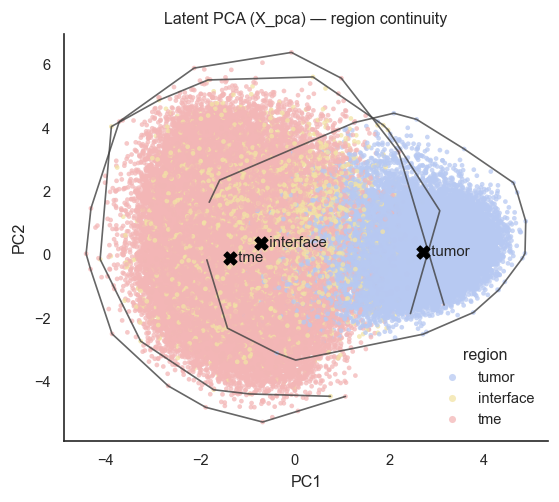

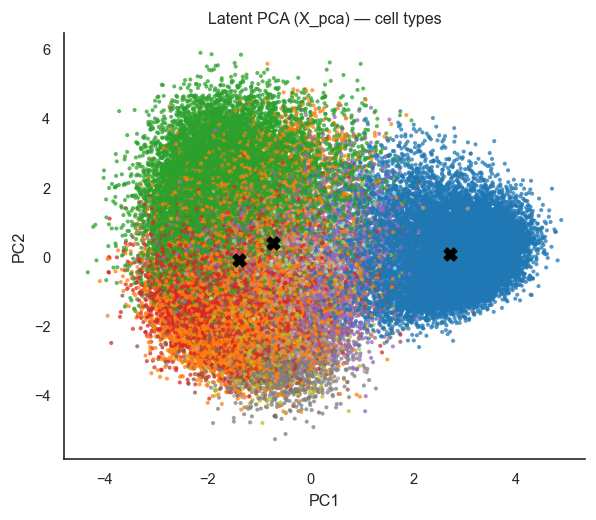

,PC1,PC2,region,cell_type
0,4.036824,-0.500886,tumor,tumor 13
1,2.775159,-0.405324,tumor,tumor 13
2,-1.945288,-2.733354,tme,fibroblast
3,-1.609858,-1.561738,tme,fibroblast
4,-2.029800,-0.167936,tme,fibroblast
...,...,...,...,...
81231,-2.477918,0.312727,tme,T CD4 memory
81232,-1.036137,-1.796442,tme,T CD4 memory
81233,-0.620988,1.140855,tme,macrophage
81234,-0.866024,0.273569,tme,T CD4 memory


In [18]:
from scipy.spatial import ConvexHull

def _convex_hulls(df, x="PC1", y="PC2", group="region", min_pts=10):
    hulls = {}
    for g, sub in df.groupby(group):
        if len(sub) >= min_pts:
            pts = sub[[x, y]].to_numpy()
            try:
                hull = ConvexHull(pts)
                hulls[g] = pts[hull.vertices]
            except Exception:
                pass
    return hulls

def figB_latent_continuity(adata, region_col, celltype_col=CELLTYPE_COL, latent_key=None,
                           palette_comp=PALETTE_COMP, palette_ct=PALETTE_CT):
    # ---- pick latent and compute PCA(2) with z-scoring
    if latent_key is None:
        latent_key = _pick_latent_key(adata, LATENT_KEYS_TRY)
    if latent_key is None:
        warnings.warn("No latent found; skipping latent continuity panels.")
        return None

    X = np.asarray(adata.obsm[latent_key])
    XY = PCA(n_components=2, random_state=0).fit_transform(
        StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    )

    # base dataframe
    df = pd.DataFrame({
        "PC1": XY[:, 0].astype(float),
        "PC2": XY[:, 1].astype(float),
        "region": adata.obs[region_col].astype(str).values,
        "cell_type": adata.obs[celltype_col].astype(str).values
    })
    # consistent region order
    order = [o for o in ["tumor", "interface", "tme"] if o in df["region"].unique()]
    df["region"] = pd.Categorical(df["region"], categories=order, ordered=True)

    # ---------- (B1) Regions panel (your compartment palette) ----------
    plt.figure(figsize=(5.2, 4.4))
    sns.scatterplot(
        data=df, x="PC1", y="PC2", hue="region", hue_order=order,
        palette=[palette_comp.get(k, "0.5") for k in order],
        s=8, linewidth=0, alpha=0.75, edgecolor=None
    )
    # centroids
    cent = df.groupby("region")[["PC1", "PC2"]].mean()
    plt.scatter(cent["PC1"], cent["PC2"], s=60, c="k", marker="X", zorder=5)
    for r in cent.index:
        plt.text(cent.loc[r, "PC1"], cent.loc[r, "PC2"], f"  {r}", va="center", ha="left", fontsize=9)

    # convex hulls per region
    hulls = _convex_hulls(df, group="region", min_pts=30)
    for r, poly in hulls.items():
        plt.plot(poly[:, 0], poly[:, 1], color="0.25", lw=1.0, alpha=0.8)

    plt.title(f"Latent PCA ({latent_key}) — region continuity")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(frameon=False, title="region", markerscale=1.5)
    sns.despine()
    _sv("B1_latent_pca_regions")
    plt.show()

    # save centroid distances + triangle ratio (float)
    if set(["tumor", "interface", "tme"]).issubset(cent.index):
        d_ti = float(np.linalg.norm(cent.loc["tumor"] - cent.loc["interface"]))
        d_im = float(np.linalg.norm(cent.loc["interface"] - cent.loc["tme"]))
        d_tm = float(np.linalg.norm(cent.loc["tumor"] - cent.loc["tme"]))
        tri_ratio = float((d_ti + d_im) / (d_tm + 1e-12))
        with open(os.path.join(OUTDIR, "B2_latent_centroid_distances.json"), "w") as f:
            json.dump({
                "latent_key": latent_key,
                "d_tumor_interface": d_ti,
                "d_interface_tme": d_im,
                "d_tumor_tme": d_tm,
                "triangle_ratio": tri_ratio
            }, f, indent=2)

    # ---------- (B1b) Cell-type panel (your CT palette; fallback to tab20) ----------
    ct_unique = df["cell_type"].unique().tolist()
    tab20 = sns.color_palette("tab20", 20)
    ct_palette = {ct: palette_ct.get(ct, tab20[hash(ct) % 20]) for ct in ct_unique}

    plt.figure(figsize=(5.6, 4.6))
    sns.scatterplot(
        data=df.sample(min(len(df), 60000), random_state=0),  # thin for speed/legibility if huge
        x="PC1", y="PC2", hue="cell_type",
        palette=ct_palette, s=6, linewidth=0, alpha=0.75, edgecolor=None, legend=False
    )
    # optional: overlay region centroids again for reference
    plt.scatter(cent["PC1"], cent["PC2"], s=60, c="k", marker="X", zorder=5)
    plt.title(f"Latent PCA ({latent_key}) — cell types")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    sns.despine()
    _sv("B1b_latent_pca_celltypes")
    plt.show()

    # export palette used (handy for Illustrator legends)
    pd.Series(ct_palette).to_csv(os.path.join(OUTDIR, "B1b_celltype_palette.csv"), header=["color"])
    return df

figB_latent_continuity(adata, REGION_COL)  